In [2]:
import numpy as np
import pandas as pd
import pickle


from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
#from modAL.models import Committee
#from modAL.disagreement import vote_entropy_sampling

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

import recordlinkage as rl

from active_learn import*
from thresholding import*

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from importlib import reload
#reload(spam)

In [3]:
#df_uns = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\df_uns_label_img_1.csv')
df_uns_red =pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\df_uns_label_img_red_hot.csv')

df_full = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\merged_clean_df.csv')
df_full.drop('Unnamed: 0',axis=1,inplace=True)

#Manually annotated data
test_1 = rl.read_annotation_file(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\result_bnb_trip.json')
test_2 = rl.read_annotation_file(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\result_bnb_vrb.json')

#Baseline with unsupervised
df_full_base = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\df_uns_label_base_train.csv')
df_full_base['label'] = df_full_base['label'].map(to_bin)

# Updated training df
#df_ams_train = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\df_ams_train_1.csv')

In [4]:
# Divide test and training set for baseline 
df_base_train = df_full_base.loc[:1761] 
df_base_test = df_full_base.loc[1762:]

In [5]:
compare(df_full,10161202, 10161074,full=False)

https://www.airbnb.nl/rooms/10161202
https://www.airbnb.nl/rooms/10161074


'Links retreived'

In [84]:
#Labeled data
open_file = open('labels_no_hotels_v.pkl', "rb")
labels_test = pickle.load(open_file)
open_file.close()
#Labeled data
open_file = open('labels-all.pkl', "rb")
labels_test_1 = pickle.load(open_file)
open_file.close()

In [85]:
#Take out the labeled data for making a test set 
manual_labeled = []

"""#Getting the Listing Ids bc the files is in index 
for x,y in test_1.links:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),1])
    manual_labeled.append([str(tuple_2),1])
    
for x,y in test_2.links:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),1])
    manual_labeled.append([str(tuple_2),1])
for x,y in test_1.distinct:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),0])
    manual_labeled.append([str(tuple_2),0])
    
for x,y in test_2.distinct:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),0])
    manual_labeled.append([str(tuple_2),0])"""
for (tuple_1,tuple_2),label in labels_test_1:
    if label ==2 :
        manual_labeled.append([str((tuple_1,tuple_2)),np.float('nan')])
        manual_labeled.append([str((tuple_2,tuple_1)),np.float('nan')])
    else:    
        manual_labeled.append([str((tuple_1,tuple_2)),label])
        manual_labeled.append([str((tuple_2,tuple_1)),label])

for (tuple_1,tuple_2),label in labels_test:
    if label ==2 :
        manual_labeled.append([str((tuple_1,tuple_2)),np.float('nan')])
        manual_labeled.append([str((tuple_2,tuple_1)),np.float('nan')])
    else:    
        manual_labeled.append([str((tuple_1,tuple_2)),label])
        manual_labeled.append([str((tuple_2,tuple_1)),label])

 #Merging to have it with the full data   
df_labeled = pd.DataFrame(manual_labeled,columns=['ids','labels'])
df_labeled
with_labels =df_uns_red.merge(df_labeled,on='ids',how='left')


In [148]:
#Comitee of models
def randomforest_com():
    clf = RandomForestClassifier()
    return clf
def desiciontree():
    clf= DecisionTreeClassifier()#criterion ='gini', max_depth= None,max_leaf_nodes= 7,min_samples_leaf= 3
    return clf
def logisticreg():
    clf = LogisticRegression()#fit_intercept= True,max_iter=150, penalty= 'l1',solver= 'saga'
    return clf
def xbg_class():
    clf = xgb.XGBClassifier() #learning_rate=0.1,max_depth= 7,n_estimators = 150
    return clf
def svm():
    clf = SVC(probability=True)#,C= 1,gamma= 0.1, kernel= 'linear'
    return clf
#Main model
def randomforest_main():
    clf = RandomForestClassifier(n_estimators=10,min_samples_split=2,warm_start=True,max_depth=5)
    return clf

In [63]:
"""
users = ["Host_first_name_jaro_winker", "Host_first_name_levenshtein_sim" , "Host_first_name_jaccard_sim"
 ,"Host_first_name_relaxed_jaccard_sim", "Host_first_name_overlap_sim", "Host_first_name_containment_sim"
         ,'Host_picture_url_jaro_winker', 'Host_picture_url_levenshtein_sim',
       'Host_picture_url_jaccard_sim', 'Host_picture_url_relaxed_jaccard_sim',
       'Host_picture_url_overlap_sim', 'Host_picture_url_containment_sim',]"""

df_ams_train =pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\Double-Listing\Code\df_ams_train_nh_1.csv')

In [64]:
# Add labels to test set 
df_ams_test = df_uns_red.merge(df_labeled,on='ids',how='inner').dropna()
#Only run the rest of the code when starting from scratch otherwise just use updated df
#df_ams_train = with_labels[with_labels.labels.isna()]
df_ams_train.rename(columns={'labels':'label'},inplace=True)
df_ams_test.rename(columns={'labels':'label'},inplace=True)
df_ams_train.drop(users,axis=1,inplace=True)
df_ams_test.drop(users,axis=1,inplace=True)


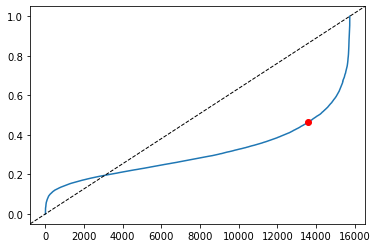

Knee of the curve is at index = 13597
Knee value = 0.46364904488754266


In [65]:
#Recalculate the uns scores after taking out the test set
df_ams_train =df_ams_train.drop(['agg_score','weights','uns_label'],axis=1)
sorted_dataset = scoring_unsupervised(df_ams_train,baseline=False)
threshold,index = elbow_threshold(sorted_dataset) 
matches_score_weight, nonmatches_score_weight = unsupervised_labels(sorted_dataset,threshold)
columns = ['ids','agg_score','weights','uns_label']
uns_labels = matches_score_weight+nonmatches_score_weight
df_uns = pd.DataFrame(uns_labels,columns=columns)
df_ams_train= df_ams_train.merge(df_uns,on='ids')

unsupervised
Iteration: 0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/5494065
https://www.airbnb.nl/rooms/14333038
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 5494065 == 14333038
Name : Centre Apartment with Private Garden == Design appartment in Amsterdam Centrum (Jordaan) !
postalcode : 1016 TX == 1016 RZ
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Alex == Anouk
Host_picture_url : https://a0.muscache.com/im/pictures/user/51a4b35e-6569-4775-ac08-6eb868aaf241.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/27797024/profile_pic/1436545429/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36976 == 52.37003
Lng : 4.88065 == 4.87997
Picture_url : https://a0.muscache.com/im/pictures/87a32e9e-0a81-4006-aa59-5ca956d07919.jpg?aki_policy=large == http

0
Iteration: 2
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/44352762
https://www.airbnb.nl/rooms/44351391
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 44352762 == 44351391
Name : Mr. Monkey - Triple Bunk Room == Mr. Monkey Cosy Double Room
postalcode : 1012 XM == 1012 XM
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 3 == 2
Host_first_name : Mr. Monkey == Mr. Monkey
Host_picture_url : https://a0.muscache.com/im/pictures/user/b74b408b-5c49-4291-b5bf-63b328bcc3e5.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/b74b408b-5c49-4291-b5bf-63b328bcc3e5.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36839000000001 == 52.36856
Lng : 4.88976 == 4.88984
Picture_url : https://a0.muscache.com/im/pictures/07f9b1de-8e8e-4553-8103-46d7caf54cee.jpg?aki_policy=large == https://a0.muscache

1
Iteration: 6
Iteration: 7
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/52120325
https://www.airbnb.nl/rooms/44365699
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 52120325 == 44365699
Name : city center - garden view == City Center - two rooms downtown
postalcode : 1017 XM == 1017 XM
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Tina == Tina
Host_picture_url : https://a0.muscache.com/im/pictures/user/699659a0-f8c5-4d67-9715-6de108d1861a.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/699659a0-f8c5-4d67-9715-6de108d1861a.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.360924 == 52.360924
Lng : 4.898329 == 4.898329
Picture_url : https://a0.muscache.com/im/pictures/586d20cc-3604-45c4-9a2c-9d6932e561c6.jpg?aki_policy=large == https://a0.muscache.co

0
Iteration: 9
Iteration: 10
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/41680836
https://www.airbnb.nl/rooms/40196568
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 41680836 == 40196568
Name : Bed&Bloom 99 == Kamer aan de mooiste gracht van Amsterdam
postalcode : 1015 HC == 1016 KH
Bedrooms : 2.0 == 1.0
Bathrooms : 2.0 == 1.0
Beds : 4.0 == 2.0
Person_capacity : 4 == 2
Host_first_name : Tessa == Tessa
Host_picture_url : https://a0.muscache.com/im/pictures/user/0a2432f0-9f0f-4993-8547-59786ca8507f.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/0a2432f0-9f0f-4993-8547-59786ca8507f.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.3746 == 52.3742
Lng : 4.87826 == 4.8793
Picture_url : https://a0.muscache.com/im/pictures/cc00bec2-a7aa-4504-b917-ca7688787458.jpg?aki_policy=large == https://a0.muscache.com/im/pic

1
Iteration: 12
Iteration: 13
Iteration: 14
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/38663393
https://www.airbnb.nl/rooms/14097604
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 38663393 == 14097604
Name : Trendy apartment 5 min from the center f Amsterdam == Light apartment on perfect location 2/4 person
postalcode : 1053 BN == 1053 BG
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.5
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Mel == Rachel
Host_picture_url : https://a0.muscache.com/im/pictures/user/0c7f6337-8d5a-4036-883e-8ba1d247bea2.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/04f0e890-3989-49e0-9dde-0df80a668373.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36695 == 52.36679
Lng : 4.86499 == 4.86567
Picture_url : https://a0.muscache.com/im/pictures/0e1c761c-a684-4679-9c79-f4d24ed6cd14.

0
Iteration: 16
Iteration: 17
Iteration: 18
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/45169008
https://www.airbnb.nl/rooms/27566540
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 45169008 == 27566540
Name : Cannabis Friendly Weber Design Studio 5 == (A) The Lux at Leidse Square 3th Floor
postalcode : 1017 PJ == 1017 PL
Bedrooms : 0.0 == 2.0
Bathrooms : 1.0 == 1.5
Beds : nan == 3.0
Person_capacity : 2 == 4
Host_first_name : Marcel And Pauline == Marcel And Pauline
Host_picture_url : https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36497 == 52.36478
Lng : 4.88061 == 4.880330000000002
Picture_url : https://a0.muscache.com/im/pictures/c660eb61-30a9

1
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
No disagreement uns labels and pred labels
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/422044
https://www.airbnb.nl/rooms/15757001
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 422044 == 15757001
Name : ? City Centre Loft #4 == Super central & spacious, overlooking Singel Canal
postalcode : 1013 GA == 1013 GA
Bedrooms : 3.0 == 2.0
Bathrooms : 2.5 == 1.0
Beds : 5.0 == 2.0
Person_capacity : 4 == 4
Host_first_name : Esther & Jan == Esther & Jan
Host_picture_url : https://a0.muscache.com/im/pictures/user/f2a2b37b-4aac-4979-bee0-1b6e26447041.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/f2a2b37b-4aac-4979-bee0-1b6e26447041.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37964 == 52.37944
Lng : 4.894419999999998 == 4.8944
Picture_url : https://a0.musc

1
Iteration: 26
Iteration: 27
No disagreement uns labels and pred labels
Iteration: 28
No disagreement uns labels and pred labels
Iteration: 29
No disagreement uns labels and pred labels


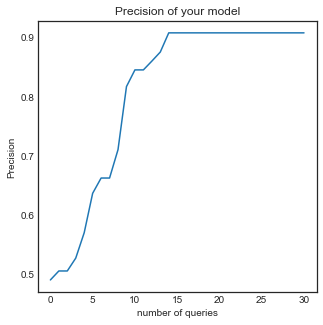

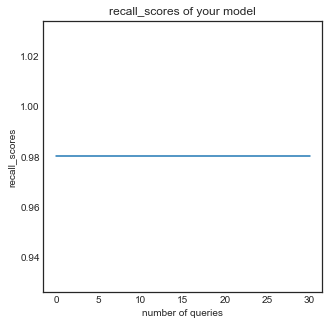

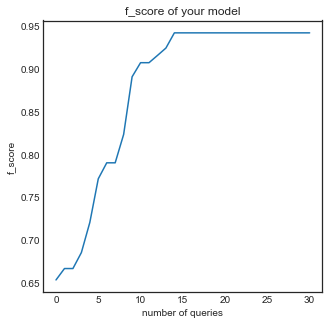

In [110]:
orcl_labels,ams_results_full = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = True,
                                        warm= True)

In [111]:
#Take out the labeled data for making a test set 
manual_labeled = []

for (tuple_1,tuple_2),label in orcl_labels:
    if label ==2 :
        manual_labeled.append([str((tuple_1,tuple_2)),np.float('nan')])
        manual_labeled.append([str((tuple_2,tuple_1)),np.float('nan')])
    else:    
        manual_labeled.append([str((tuple_1,tuple_2)),label])
        manual_labeled.append([str((tuple_2,tuple_1)),label])

#Save the labeled data into the main dataframe
for tuples,label in manual_labeled:
    df_ams_train['label'][df_ams_train['ids']== tuples] = label

unsupervised
Iteration: 0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/31536003
https://www.airbnb.nl/rooms/15658599
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 31536003 == 15658599
Name : Spacious bright family apartment + rooftop terrace == Roomy family home near city centre (2p + 1 child)
postalcode : 1056 VS == 1056 HN
Bedrooms : 3.0 == 2.0
Bathrooms : 1.5 == 1.0
Beds : 3.0 == 2.0
Person_capacity : 4 == 2
Host_first_name : Wouter == Jeroen
Host_picture_url : https://a0.muscache.com/im/users/4145047/profile_pic/1428413202/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/c4480478-35d1-4343-9fbb-a55b11c91225.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.37241 == 52.37333
Lng : 4.8612199999999985 == 4.86027
Picture_url : https://a0.muscache.com/im/pictures/a824a30a-f13b-45dc-8044-e90b6511f567.jpg?ak

0
Iteration: 2
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/44424037
https://www.airbnb.nl/rooms/44423973
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 44424037 == 44423973
Name : ? Luxurious, boutique apartment in city center with patio! == ? Light & charming apartment in lovely ''De Pijp'' neighborhood with sunny balcony
postalcode : 1073 LM == 1074 AB
Bedrooms : 2.0 == 2.0
Bathrooms : 2.0 == 2.0
Beds : 4.0 == 4.0
Person_capacity : 4 == 4
Host_first_name : Pauline == Pauline
Host_picture_url : https://a0.muscache.com/im/pictures/user/fc2398f9-9cbb-4a68-b085-fd9523a41154.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/fc2398f9-9cbb-4a68-b085-fd9523a41154.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35638 == 52.35669
Lng : 4.89961 == 4.89979
Picture_url : https://a0.muscache.com/im/pictures/26da1983-06e0-442

0
Iteration: 4
Iteration: 5
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/978852
https://www.airbnb.nl/rooms/7472412
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 978852 == 7472412
Name : Cozy Room in Amsterdam West == private studio (with private kitchen+bathroom)
postalcode : 1056 WK == 1056 GL
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Sjoukje == Vincent
Host_picture_url : https://a0.muscache.com/im/users/3879155/profile_pic/1404848897/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/39137655/profile_pic/1437646447/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.37225 == 52.37128
Lng : 4.86262 == 4.86193
Picture_url : https://a0.muscache.com/im/pictures/24784660/8f1b882b_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictures

1
Iteration: 8
Iteration: 9
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/9659173
https://www.airbnb.nl/rooms/13419312
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 9659173 == 13419312
Name : Lovely home near Jordaan&Westerpark == Heerlijk paleisje, 2 etages bij Westerpark-Jordaan
postalcode : 1051 VB == 1051 GD
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 1.5
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Charlie == Hans
Host_picture_url : https://a0.muscache.com/im/pictures/user/c73c0fae-29d3-462d-a7c3-a51d45589698.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/19617153/profile_pic/1407410824/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.38443 == 52.38371
Lng : 4.87415 == 4.8743
Picture_url : https://a0.muscache.com/im/pictures/3e66381f-9b81-405a-b257-d017d11cc9b9.jpg?aki_policy=large == https:/

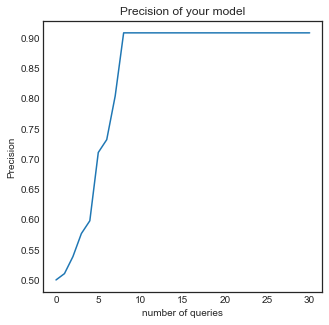

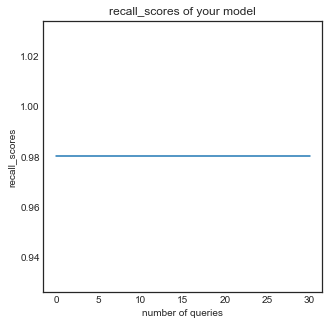

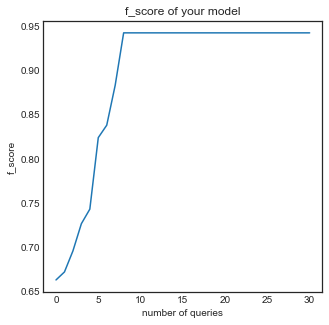

In [112]:
orcl_labels,ams_results_full_1 = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = True,
                                        warm= True)

In [113]:
#Take out the labeled data for making a test set 
manual_labeled = []

for (tuple_1,tuple_2),label in orcl_labels:
    if label ==2 :
        manual_labeled.append([str((tuple_1,tuple_2)),np.float('nan')])
        manual_labeled.append([str((tuple_2,tuple_1)),np.float('nan')])
    else:    
        manual_labeled.append([str((tuple_1,tuple_2)),label])
        manual_labeled.append([str((tuple_2,tuple_1)),label])

#Save the labeled data into the main dataframe
for tuples,label in manual_labeled:
    df_ams_train['label'][df_ams_train['ids']== tuples] = label

unsupervised
Iteration: 0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/23607656
https://www.airbnb.nl/rooms/11822995
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 23607656 == 11822995
Name : Lovely apartment in Amsterdam == Nice, clean and Cosy Appartment
postalcode : 1057 BB == 1057 AA
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Marjolijn == Jeroen
Host_picture_url : https://a0.muscache.com/im/pictures/user/19de32d4-19d5-4743-93f9-e623a305140d.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/91692323-4ec7-4965-aa04-54dc51fa31c8.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36535 == 52.36522
Lng : 4.85131 == 4.850619999999998
Picture_url : https://a0.muscache.com/im/pictures/0a7d747a-ab55-4b8f-a9f2-254d1f9b46b7.jpg?aki_policy=large == https://a0.mus

0
Iteration: 2
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/42446222
https://www.airbnb.nl/rooms/42446188
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 42446222 == 42446188
Name : Bright Nordic Designed Apartment with River View == Central, Exclusive Penthouse with River View
postalcode : 1011 AC == 1011 AC
Bedrooms : 2.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 3.0 == 2.0
Person_capacity : 5 == 4
Host_first_name : Eric == Eric
Host_picture_url : https://a0.muscache.com/im/pictures/user/4c953fe5-160e-44f9-981a-548087279fd1.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/4c953fe5-160e-44f9-981a-548087279fd1.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37754 == 52.37754
Lng : 4.90699 == 4.90699
Picture_url : https://a0.muscache.com/im/pictures/711f12be-cc4f-4a46-9bb4-e728556dc260.jpg?aki_policy=large == http

0
Iteration: 5
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/37804394
https://www.airbnb.nl/rooms/37803291
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 37804394 == 37803291
Name : Luxurious Cozy Studio | Edge Of City Center == Elegant Stylish Studio | Close 2 City Center
postalcode : 1019 AA == 1019 AS
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Lida == Liessanne
Host_picture_url : https://a0.muscache.com/im/pictures/user/5903e122-e16f-4b6c-aef3-5c29ec204511.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/ed8abe2d-d3df-42a1-973d-6e2ca803d928.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.36705 == 52.36723
Lng : 4.9339900000000005 == 4.9339
Picture_url : https://a0.muscache.com/im/pictures/51117cf1-4695-4cd3-83ec-79973d6ec5d3.jpg?aki_policy=large == 

0
Iteration: 7
Iteration: 8
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/38417080
https://www.airbnb.nl/rooms/23971011
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 38417080 == 23971011
Name : Studio RAI == Spacious three-bedroom appartment with roofterrace
postalcode : 1078 JM == 1078 GE
Bedrooms : 1.0 == 3.0
Bathrooms : 1.5 == 1.5
Beds : nan == 3.0
Person_capacity : 2 == 4
Host_first_name : Guy == Marije
Host_picture_url : https://a0.muscache.com/im/pictures/user/4047b26b-dd04-450a-b937-f73bba92824c.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/0b127d93-9196-4532-8672-a53cf0b88319.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.3457 == 52.34662
Lng : 4.89228 == 4.89105
Picture_url : https://a0.muscache.com/im/pictures/bbe1cea0-8342-4ef9-b341-84b318639619.jpg?aki_policy=large == https://a0.muscache.com/im/pi

1
Iteration: 24
No disagreement uns labels and pred labels
Iteration: 25
No disagreement uns labels and pred labels
Iteration: 26
No disagreement uns labels and pred labels
Iteration: 27
No disagreement uns labels and pred labels
Iteration: 28
No disagreement uns labels and pred labels
Iteration: 29
No disagreement uns labels and pred labels


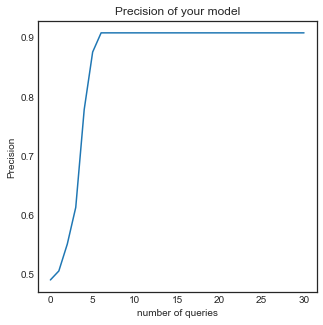

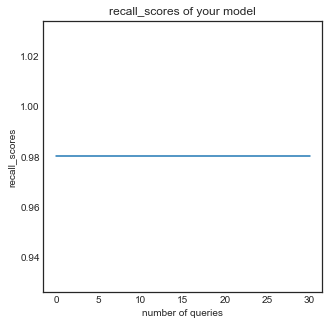

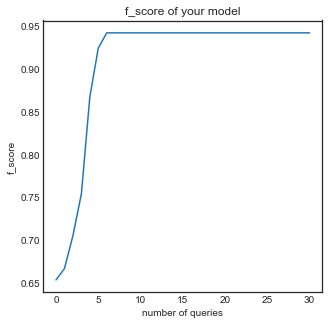

In [114]:
orcl_labels,ams_results_full_2 = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = True,
                                        warm= True)

In [115]:
#Take out the labeled data for making a test set 
manual_labeled = []

for (tuple_1,tuple_2),label in orcl_labels:
    if label ==2 :
        manual_labeled.append([str((tuple_1,tuple_2)),np.float('nan')])
        manual_labeled.append([str((tuple_2,tuple_1)),np.float('nan')])
    else:    
        manual_labeled.append([str((tuple_1,tuple_2)),label])
        manual_labeled.append([str((tuple_2,tuple_1)),label])

#Save the labeled data into the main dataframe
for tuples,label in manual_labeled:
    df_ams_train['label'][df_ams_train['ids']== tuples] = label

unsupervised
Iteration: 0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/3841339
https://www.airbnb.nl/rooms/3261562
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 3841339 == 3261562
Name : Mooi modern appartement te huur! == Cute house with garden near centre
postalcode : 1094 KT == 1094 JS
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Manja == Luc
Host_picture_url : https://a0.muscache.com/im/users/19793596/profile_pic/1407863968/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/73e68c03-4fe6-4dce-a47d-543819c7b9c6.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.36253 == 52.36306
Lng : 4.93751 == 4.93611
Picture_url : https://a0.muscache.com/im/pictures/0824e717-56ce-42f3-8b9e-71e786d1e7bb.jpg?aki_policy=large == https://a0.muscache.com/im/pictu

0
Iteration: 2
Iteration: 3
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/45169008
https://www.airbnb.nl/rooms/24640641
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 45169008 == 24640641
Name : Cannabis Friendly Weber Design Studio 5 == (B) Cannabis Friendly - The Blake first Floor -420
postalcode : 1017 PJ == 1017 PJ
Bedrooms : 0.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : nan == 1.0
Person_capacity : 2 == 4
Host_first_name : Marcel And Pauline == Marcel And Pauline
Host_picture_url : https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36497 == 52.3649
Lng : 4.88061 == 4.88066
Picture_url : https://a0.muscache.com/im/pictures/c660eb61-30a9-4672-98f6-9b84

0
Iteration: 6
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/9619832
https://www.airbnb.nl/rooms/16270813
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 9619832 == 16270813
Name : 2 Floor Canal Apartment in Center of AMS (De Pijp) == Fantastic ground floor apartment in the center!
postalcode : 1072 TK == 1072 AR
Bedrooms : 2.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : nan == 2.0
Person_capacity : 4 == 4
Host_first_name : Menno == Menke
Host_picture_url : https://a0.muscache.com/im/pictures/user/f7715c3a-f51a-4c35-a0ca-fd839c014542.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/f17ef0b9-d58a-4211-a3e1-dc544bd66c92.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35312 == 52.35378
Lng : 4.88813 == 4.88702
Picture_url : https://a0.muscache.com/im/pictures/817a32b3-14e2-47b0-b8b0-0180ca7ce523.jpg?aki_policy=large == https

0
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/31831416
https://www.airbnb.nl/rooms/2871016
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 31831416 == 2871016
Name : Wonderful loft, central & with amazing canal view == Spacious loft appartment in center of Jordaan area
postalcode : 1013 HB == 1015 GC
Bedrooms : 2.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 3.0 == 1.0
Person_capacity : 4 == 4
Host_first_name : Caterina == Christophe
Host_picture_url : https://a0.muscache.com/im/users/2890590/profile_pic/1341928277/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/14674897/profile_pic/1398350224/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.38104000000001 == 52.38009
Lng : 4.88813 == 4.88874
Picture_url : https://a0.muscache.com/im/pictures/1bc6cea9-

0
Iteration: 23
No disagreement uns labels and pred labels
Iteration: 24
No disagreement uns labels and pred labels
Iteration: 25
No disagreement uns labels and pred labels
Iteration: 26
No disagreement uns labels and pred labels
Iteration: 27
No disagreement uns labels and pred labels
Iteration: 28
No disagreement uns labels and pred labels
Iteration: 29
No disagreement uns labels and pred labels


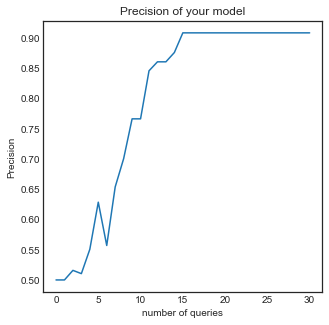

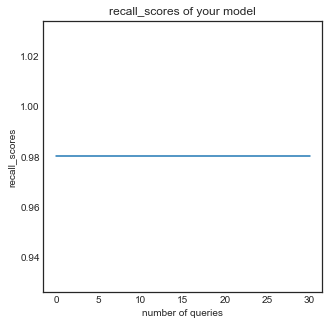

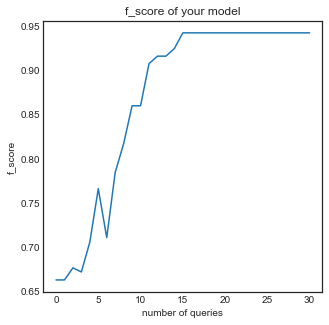

In [116]:
orcl_labels,ams_results_full_3 = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = True,
                                        warm= True)

In [117]:
#Take out the labeled data for making a test set 
manual_labeled = []

for (tuple_1,tuple_2),label in orcl_labels:
    if label ==2 :
        manual_labeled.append([str((tuple_1,tuple_2)),np.float('nan')])
        manual_labeled.append([str((tuple_2,tuple_1)),np.float('nan')])
    else:    
        manual_labeled.append([str((tuple_1,tuple_2)),label])
        manual_labeled.append([str((tuple_2,tuple_1)),label])

#Save the labeled data into the main dataframe
for tuples,label in manual_labeled:
    df_ams_train['label'][df_ams_train['ids']== tuples] = label

unsupervised
Iteration: 0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/4860508
https://www.airbnb.nl/rooms/31831416
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 4860508 == 31831416
Name : Amazing Houseboat on best spot ever == Wonderful loft, central & with amazing canal view
postalcode : 1013 GT == 1013 HB
Bedrooms : 1.0 == 2.0
Bathrooms : 1.5 == 1.0
Beds : 2.0 == 3.0
Person_capacity : 2 == 4
Host_first_name : Joost == Caterina
Host_picture_url : https://a0.muscache.com/im/pictures/user/71e6ec19-726a-4ca9-9e0d-9543ba866d16.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/2890590/profile_pic/1341928277/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.38116 == 52.38104000000001
Lng : 4.88845 == 4.88813
Picture_url : https://a0.muscache.com/im/pictures/60945927/f79dfcee_original.jpg?aki_policy=large == http

0
Iteration: 2
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/42288239
https://www.airbnb.nl/rooms/42287405
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 42288239 == 42287405
Name : Lovely room for two close to Amstel river == Fantastic Amsterdam group apartment close to city centre
postalcode : 1096 AM == 1096 AM
Bedrooms : 1.0 == 4.0
Bathrooms : 1.5 == 2.0
Beds : 2.0 == 12.0
Person_capacity : 2 == 12
Host_first_name : Peter == Peter
Host_picture_url : https://a0.muscache.com/im/pictures/user/5cdd95f8-5645-48c2-a5a5-89a4a836e1a9.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/5cdd95f8-5645-48c2-a5a5-89a4a836e1a9.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.33681 == 52.33696
Lng : 4.93101 == 4.93201
Picture_url : https://a0.muscache.com/im/pictures/ee31693e-9abb-4f8e-888c-a8eeccb6f2e4.jpg?aki_policy=large == h

0
Iteration: 4
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/35145947
https://www.airbnb.nl/rooms/20164112
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 35145947 == 20164112
Name : Beautiful light and spacious house in the centre. == Beautiful 95m2 Canal House  garden @Jordaan
postalcode : 1015 ZJ == 1015 ZJ
Bedrooms : 5.0 == 1.0
Bathrooms : 2.0 == 1.0
Beds : 5.0 == 1.0
Person_capacity : 10 == 2
Host_first_name : Jelle == Laurens
Host_picture_url : https://a0.muscache.com/im/users/6764968/profile_pic/1370502591/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/b1aa9657-8e64-4132-9686-365776a9fade.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37647 == 52.37613
Lng : 4.87705 == 4.87697
Picture_url : https://a0.muscache.com/im/pictures/be9cf6c9-f159-4491-bfec-a91bc1bb6c3a.jpg?aki_policy=large == http

0
Iteration: 6
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/42947192
https://www.airbnb.nl/rooms/24296667
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 42947192 == 24296667
Name : Cannabis Friendly Weber Design Studio 3 == (A) The Lux at Leidse Square GroundFloor 240M2
postalcode : 1016 XN == 1017 PL
Bedrooms : 0.0 == 2.0
Bathrooms : 1.0 == 2.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 4
Host_first_name : Marcel And Pauline == Marcel And Pauline
Host_picture_url : https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36586 == 52.36478
Lng : 4.88085 == 4.880330000000002
Picture_url : https://a0.muscache.com/im/pictures/7932e6f5-cbae-4ef5-9db6-2b4b52757c

0
Iteration: 8
Iteration: 9
Iteration: 10
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/53214172
https://www.airbnb.nl/rooms/31709186
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 53214172 == 31709186
Name : Bright apartment next to Amstel, 3 outdoor spaces == Lovely apartment in the most vibrant area
postalcode : 1074 EC == 1074 BN
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 1.0
Beds : nan == 2.0
Person_capacity : 2 == 2
Host_first_name : Alex == Guillaume
Host_picture_url : https://a0.muscache.com/im/pictures/user/8ec01ff0-5968-4093-807a-825e616f315d.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/8f647462-d4ba-473f-87b0-e9b7123bad54.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 1 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.3556774597301 == 52.35662
Lng : 4.90440826243715 == 4.9032300000000015
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-

0
Iteration: 13
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/6863052
https://www.airbnb.nl/rooms/44280700
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 6863052 == 44280700
Name : Light apartment with large balcony near centre == Private modern apartment in De Pijp.
postalcode : 1074 JH == 1074 HS
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 1.5
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Stephanie == Rose
Host_picture_url : https://a0.muscache.com/im/users/10048959/profile_pic/1434483377/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/607627cb-3474-42ab-9bef-facb7ff3b132.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35736 == 52.35683
Lng : 4.90468 == 4.90425
Picture_url : https://a0.muscache.com/im/pictures/8a81682b-d2f9-4a67-8bb6-14feb78b93e4.jpg?aki_policy=large == https://a0.muscache

0
Iteration: 15
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/36972460
https://www.airbnb.nl/rooms/27379405
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 36972460 == 27379405
Name : Cozy apartment in lively area, close to Vondelpark == Light and central apartment, canalview
postalcode : 1053 GP == 1053 SB
Bedrooms : 2.0 == 2.0
Bathrooms : 15.0 == 15.0
Beds : 2.0 == 3.0
Person_capacity : 4 == 4
Host_first_name : Ana == Susanne
Host_picture_url : https://a0.muscache.com/im/pictures/user/d79668ff-76c6-4b69-9f06-f92cea0aeb25.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/080fc936-068e-4d64-a87b-bf97ceb33e30.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36506 == 52.36616
Lng : 4.86239 == 4.86215
Picture_url : https://a0.muscache.com/im/pictures/615ea044-0221-4db3-8bf7-ead2a6ff178b.jpg?aki_policy=large == https://a

0
Iteration: 17
Iteration: 18
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/33767056
https://www.airbnb.nl/rooms/14461859
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 33767056 == 14461859
Name : Private apartment for rent (Close to Jordaan) == Colorful, light and cosy apartment near Westerpark
postalcode : 1051 GJ == 1051 VM
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Maaike == Elza
Host_picture_url : https://a0.muscache.com/im/pictures/user/5fc3bee7-dd73-4e14-b0ba-33e3da95b227.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/3db10f6c-f8cb-4e50-a21e-f1ffa092b6e0.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.38303 == 52.38434
Lng : 4.87141 == 4.87099
Picture_url : https://a0.muscache.com/im/pictures/4272699a-053f-4857-825f-0cd39f980f60.jpg?aki_polic

0
Iteration: 20
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/34492672
https://www.airbnb.nl/rooms/17050106
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 34492672 == 17050106
Name : Fantastic 1-bedroom apartment in Amsterdam OldWest == Independent studio with canal views
postalcode : 1057 JN == 1053 TJ
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Chris == Joost, Cristina And Lima
Host_picture_url : https://a0.muscache.com/im/pictures/user/862d6d99-bfff-46f3-896e-bc1b7420cde5.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/31b9e5aa-f5cb-4115-9d04-9dedbf80d0ce.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36957 == 52.36842
Lng : 4.86302 == 4.86405
Picture_url : https://a0.muscache.com/im/pictures/3b403f35-0adb-4fe1-bf62-6c7fa981b33d.jpg?aki_policy=larg

0
Iteration: 23
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/8189988
https://www.airbnb.nl/rooms/29007722
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 8189988 == 29007722
Name : A very cozy apartment in Amsterdam == Beautiful and bright apartment in Amsterdam
postalcode : 1072 XW == 1072 BJ
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 15.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Bogy == Marie-Anne
Host_picture_url : https://a0.muscache.com/im/pictures/user/014d19f6-1449-4ba7-a1e7-fac0236719ad.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/09c2d8d3-e7ec-459e-a6ea-dfe77932bc89.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35654 == 52.35776
Lng : 4.89015 == 4.88927
Picture_url : https://a0.muscache.com/im/pictures/6fe0c4fe-7e66-4dfc-809a-35e768cc8715.jpg?aki_policy=large == https://a0.muscache

0
Iteration: 25
Iteration: 26
Iteration: 27
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/40701237
https://www.airbnb.nl/rooms/17932670
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 40701237 == 17932670
Name : Modern & Spacious apartment with nice garden! == Bright, spacious & trendy apartment with rooftop!
postalcode : 1056 SK == 1056 RZ
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 2.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Tom == Lizzy
Host_picture_url : https://a0.muscache.com/im/pictures/user/8bbafb7d-4c93-421a-8cd0-b09b98f7ebdf.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/3587641/profile_pic/1413895366/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.37247 == 52.37145
Lng : 4.85278 == 4.85239
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-40701237/original/1664f661-5789-

0
Iteration: 29


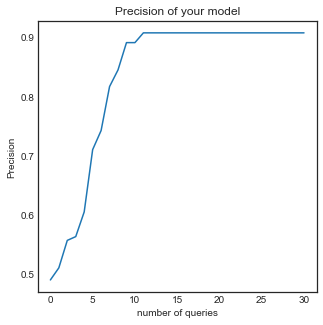

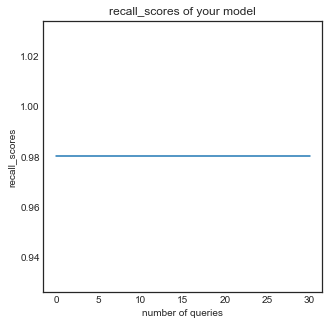

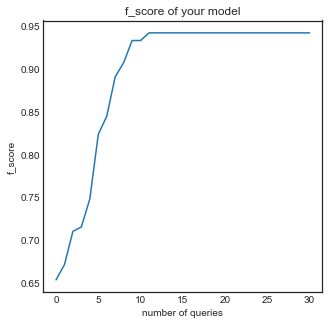

In [118]:
orcl_labels,ams_results_full_4 = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = True,
                                        warm= True)

In [119]:
#Take out the labeled data for making a test set 
manual_labeled = []

for (tuple_1,tuple_2),label in orcl_labels:
    if label ==2 :
        manual_labeled.append([str((tuple_1,tuple_2)),np.float('nan')])
        manual_labeled.append([str((tuple_2,tuple_1)),np.float('nan')])
    else:    
        manual_labeled.append([str((tuple_1,tuple_2)),label])
        manual_labeled.append([str((tuple_2,tuple_1)),label])

#Save the labeled data into the main dataframe
for tuples,label in manual_labeled:
    df_ams_train['label'][df_ams_train['ids']== tuples] = label

In [120]:
resuts_full_ams = [ams_results_full,ams_results_full_1,ams_results_full_2,ams_results_full_3,ams_results_full_4]

file_name = "resuts_full_rf_ams_red.pkl"

open_file = open(file_name, "wb")
pickle.dump(resuts_full_ams, open_file)
open_file.close()

In [121]:
#len(df_ams_train.label.dropna())
df_ams_train.to_csv('df_ams_train_nh_1.csv',index=False)

Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/7276869
https://www.airbnb.nl/rooms/41768028
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 7276869 == 41768028
Name : Clean, Quiet, Lovers Retreat == Sunny apartment in De Pijp 100m from Sarphati Park
postalcode : 1074 AB == 1073 VP
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 1.0 == 2.0
Person_capacity : 2 == 2
Host_first_name : Ruben == Robert
Host_picture_url : https://a0.muscache.com/im/users/37658666/profile_pic/1438095049/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/8080224f-3aa4-46ac-8dc5-d1448731079d.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35668 == 52.35581
Lng : 4.89999 == 4.89958
Picture_url : https://a0.muscache.com/im/pictures/7515700b-1b29-46e5-9ce9-8db1c060099f.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/0238b8

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/44310951
https://www.airbnb.nl/rooms/35302424
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 44310951 == 35302424
Name : ? Luxurious, authentic canal view Amsterdam apartment in city center! == Modern family home
postalcode : 1073 AW == 1073 XK
Bedrooms : 2.0 == 3.0
Bathrooms : 2.0 == 1.0
Beds : 4.0 == 3.0
Person_capacity : 4 == 4
Host_first_name : Pauline == Joanneke
Host_picture_url : https://a0.muscache.com/im/pictures/user/fc2398f9-9cbb-4a68-b085-fd9523a41154.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/e1dcfa64-aad1-43e7-94b6-7c871644827d.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35784 == 52.3566
Lng : 4.8958 == 4.8953
Picture_url : https://a0.muscache.com/im/pictures/f9143f41-bcf1-4815-b8df-66c5bb7847f0.jpg?aki_policy=large == https://a0.muscache.com/

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/40668309
https://www.airbnb.nl/rooms/3786000
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 40668309 == 3786000
Name : Modern apartment near Vondelpark/9 streets == Little room, groundfloor, close to the City Centre
postalcode : 1054 VV == 1054 WJ
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : nan == 1.0
Person_capacity : 2 == 2
Host_first_name : Jan == Annet
Host_picture_url : https://a0.muscache.com/im/pictures/user/8dcd5bd1-ea0c-4842-bf02-64747d995ffe.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/19279371/profile_pic/1406897686/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36223 == 52.36245
Lng : 4.86615 == 4.86581
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-40668309/original/98860e8e-952e-47e0-818e-d4c9dcfe5918.jpeg?aki_policy=large 

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/40822137
https://www.airbnb.nl/rooms/29003215
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 40822137 == 29003215
Name : Soft Spaciously Central River Living == Tower Studio at YAYS Amsterdam Maritime
postalcode : 1018 HL == 1018 HN
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 3 == 2
Host_first_name : Nike == Yays Oostenburgergracht
Host_picture_url : https://a0.muscache.com/im/users/2202315/profile_pic/1338734512/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/40766d8b-793c-4861-8e5e-6e5e3ef008ad.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36914 == 52.36913
Lng : 4.92395 == 4.9231099999999985
Picture_url : https://a0.muscache.com/im/pictures/63088c12-358e-41c9-9d11-d7f42c0ddbb6.jpg?aki_policy=large == https://a

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/32234536
https://www.airbnb.nl/rooms/31453479
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 32234536 == 31453479
Name : One Bedroom Superior Apartment == b&b einstein was here amsterdam centrum albert II
postalcode : 1018 VL == 1018 VG
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Wittenberg == Claartje
Host_picture_url : https://a0.muscache.com/im/pictures/user/fb79a2a5-ea38-4539-b7d1-9d0818f6670b.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/9968b43d-e51e-433f-86da-81511d182b10.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36536 == 52.36469
Lng : 4.9089800000000015 == 4.90974
Picture_url : https://a0.muscache.com/im/pictures/d06ff95e-0a06-41bd-ad39-de9fb9f9e9a8.jpg?aki_policy=large == https://a

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/53077427
https://www.airbnb.nl/rooms/45263913
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 53077427 == 45263913
Name : Spacious apartment in the centre of de Pijp! == Beautiful design house in 'de Pijp' + garden
postalcode : 1072 EM == 1072 TR
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 1.0
Beds : nan == 1.0
Person_capacity : 2 == 2
Host_first_name : Ruurd == Rianne
Host_picture_url : https://a0.muscache.com/im/pictures/user/55c2aa76-1a53-4fc2-a48a-62d50e99a7f5.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/7eec80a4-88f3-426d-a94b-d764e78d84b7.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 1 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.3544824837737 == 52.35372
Lng : 4.89119429080568 == 4.89213
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-53077427/original/de19b87c-0209-42c7-bbac-1152a678a8c5

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/35971106
https://www.airbnb.nl/rooms/1954182
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 35971106 == 1954182
Name : Apartment with terrace & bath, 2 min to Jordaan == Oud-West/Jordaan with canal view
postalcode : 1053 ZV == 1053 WJ
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Sjoerd & Rosalie == Erik
Host_picture_url : https://a0.muscache.com/im/pictures/user/910f35ae-f878-4581-981c-983079ad6880.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/9905351/profile_pic/1384807494/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.37027 == 52.36984
Lng : 4.873469999999998 == 4.87213
Picture_url : https://a0.muscache.com/im/pictures/c61c11fd-fc4e-42c8-b6ad-ef5a27540bc6.jpg?aki_policy=large == https://a0.muscache.c

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/22919004
https://www.airbnb.nl/rooms/12213244
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 22919004 == 12213244
Name : Bright apartment in popular area, close to Centre! == Simple Living, Colourful Life
postalcode : 1053 AT == 1053 WC
Bedrooms : 2.0 == 2.0
Bathrooms : 15.0 == 15.0
Beds : 3.0 == 2.0
Person_capacity : 4 == 4
Host_first_name : Kwok-Wah (Kokkie) == Emily
Host_picture_url : https://a0.muscache.com/im/users/5505945/profile_pic/1363562178/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/ce2f0f45-db4b-42f1-805f-c5c09f808130.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36824 == 52.36814
Lng : 4.86689 == 4.86832
Picture_url : https://a0.muscache.com/im/pictures/96fdf0e9-772d-4563-a3bd-fed73d712f49.jpg?aki_policy=large == https://a0.muscache.com/i

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/1943465
https://www.airbnb.nl/rooms/11697661
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 1943465 == 11697661
Name : lovely houseboat with large terrace == Apartment on trendy hotspot in Food Hallen
postalcode : 1053 DM == 1053 CC
Bedrooms : 2.0 == 1.0
Bathrooms : 15.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Rob == Noor
Host_picture_url : https://a0.muscache.com/im/users/10052583/profile_pic/1386535030/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/4c79a389-ce76-4093-b058-27d8447bcd89.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36603 == 52.36632
Lng : 4.8689800000000005 == 4.86749
Picture_url : https://a0.muscache.com/im/pictures/43309866/46e99d54_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/35f6c4a

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/39143576
https://www.airbnb.nl/rooms/3430456
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 39143576 == 3430456
Name : Luxury two-floor apartment with roof terrace, 90m2 == lovely apartment with balcony
postalcode : 1054 ZT == 1054 WS
Bedrooms : 2.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Vivianne == Monique
Host_picture_url : https://a0.muscache.com/im/pictures/user/3c54676a-32ab-454a-86e9-cb188b09c724.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/22ce2ac7-2d86-493e-ae62-cf15a4ce4806.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36157 == 52.36099
Lng : 4.85957 == 4.85987
Picture_url : https://a0.muscache.com/im/pictures/55236aeb-29e3-4174-b736-7e968a230d3c.jpg?aki_policy=large == https://a0.muscache.com/im/pict

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/1482038
https://www.airbnb.nl/rooms/14017497
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 1482038 == 14017497
Name : Amazing Amsterdam Canalside Loft == Perfect Studio in Amsterdam Center!
postalcode : 1015 GB == 1013 EE
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Mark == Rutger
Host_picture_url : https://a0.muscache.com/im/users/7928859/profile_pic/1409955455/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/7c07a889-cd0e-4bb9-8fc1-d3a83604b078.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37938 == 52.37998
Lng : 4.89036 == 4.89086
Picture_url : https://a0.muscache.com/im/pictures/pro_photo_tool/Hosting-1482038-unapproved/original/5cea0864-7d5b-42ae-946b-24cc625222ae.JPEG?aki_policy=larg

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/32485928
https://www.airbnb.nl/rooms/1113862
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 32485928 == 1113862
Name : New Pijp Studio == Great spacious apartment (De Pijp)
postalcode : 1073 GC == 1073 TB
Bedrooms : 0.0 == 0.0
Bathrooms : 1.0 == 1.0
Beds : nan == 2.0
Person_capacity : 2 == 2
Host_first_name : Paul & Mariana == Geraldien
Host_picture_url : https://a0.muscache.com/im/pictures/user/36b771e8-539f-44d2-a0f4-0c86193db51c.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/6113063/profile_pic/1412790970/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35232 == 52.35174
Lng : 4.89795 == 4.89701
Picture_url : https://a0.muscache.com/im/pictures/317dc9f0-602d-45ae-a752-83eef508f6e0.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/91527194/78ac5878_orig

0
(28, 99) (28,)
Iteration: 0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/11161861
https://www.airbnb.nl/rooms/11161348
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 11161861 == 11161348
Name : Cozy Stylish room @ Leidseplein == Spacious Stylish room @ Leidseplein
postalcode : 1017 PT == 1017 PT
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.5
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Yvo == Yvo
Host_picture_url : https://a0.muscache.com/im/pictures/user/253d2d2f-f62f-4141-9afe-18c83682fe07.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/253d2d2f-f62f-4141-9afe-18c83682fe07.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36418 == 52.36399
Lng : 4.88261 == 4.88232
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-11161861/original/11d46513-b832-4a72-a5ab-473a10ada962.jpeg?aki_p

1
Iteration: 3
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/50515620
https://www.airbnb.nl/rooms/50474051
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 50515620 == 50474051
Name : Cannabis Friendly (G) Freeland Studio 7 == Cannabis Friendly (G) Freeland Studio 4
postalcode : nan == nan
Bedrooms : 0.0 == 0.0
Bathrooms : 1.0 == 1.0
Beds : nan == 1.0
Person_capacity : 2 == 2
Host_first_name : Marcel == Marcel
Host_picture_url : https://a0.muscache.com/im/pictures/user/741d6d13-1eb7-4410-9fef-6fec66aff2e4.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/741d6d13-1eb7-4410-9fef-6fec66aff2e4.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : centrumoost == centrumoost
Lat : 52.364883 == 52.364883
Lng : 4.880225 == 4.880225
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-50515620/original/99aeffe2-e11a-4c72-91f9-314b7fe8e47d.jpeg?aki_policy=large

1
Iteration: 5
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/31215469
https://www.airbnb.nl/rooms/24296667
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 31215469 == 24296667
Name : (B) Cannabis Friendly - The Blake 3rd Floor -420 == (A) The Lux at Leidse Square GroundFloor 240M2
postalcode : 1017 PH == 1017 PL
Bedrooms : 2.0 == 2.0
Bathrooms : 1.0 == 2.0
Beds : 3.0 == 2.0
Person_capacity : 4 == 4
Host_first_name : Marcel And Pauline == Marcel And Pauline
Host_picture_url : https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36519000000001 == 52.36478
Lng : 4.88151 == 4.880330000000002
Picture_url : https://a0.muscache.com/im/pictures/b5744326-eda7-4b

0
Iteration: 7
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/29124691
https://www.airbnb.nl/rooms/21421856
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 29124691 == 21421856
Name : Spacious apartment in the center of de Pijp == Cozy& renovated appartment in Amsterdam de Pijp
postalcode : 1072 EX == 1072 EX
Bedrooms : 3.0 == 1.0
Bathrooms : 2.0 == 1.0
Beds : 3.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Anne == Britt
Host_picture_url : https://a0.muscache.com/im/pictures/user/2ecaaef4-f3d5-41b9-8c3f-b6d97ada1e56.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/bc8847bf-fe25-4e68-b580-a818d4d0c79e.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35305 == 52.35307
Lng : 4.89162 == 4.89153
Picture_url : https://a0.muscache.com/im/pictures/9cbcb8d6-0a42-4d9d-8afd-7e8b477c5f1f.jpg?aki_policy=large == https://a0.

0
Iteration: 9
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/42291162
https://www.airbnb.nl/rooms/42288239
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 42291162 == 42288239
Name : Lovely and romantic room for two near Amstel River == Lovely room for two close to Amstel river
postalcode : 1096 AM == 1096 AM
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.5
Beds : 2.0 == 2.0
Person_capacity : 2 == 2
Host_first_name : Peter == Peter
Host_picture_url : https://a0.muscache.com/im/pictures/user/5cdd95f8-5645-48c2-a5a5-89a4a836e1a9.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/5cdd95f8-5645-48c2-a5a5-89a4a836e1a9.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.33652 == 52.33681
Lng : 4.93064 == 4.93101
Picture_url : https://a0.muscache.com/im/pictures/75650404-c26b-4ce6-940a-a7b9b34ce0fa.jpg?aki_policy=large == https://a

1
Iteration: 11
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/40646070
https://www.airbnb.nl/rooms/40150321
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 40646070 == 40150321
Name : Canal view house with balcony in city center! == Amazing canal-view house in city-center!
postalcode : 1015 ZA == 1015 VT
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 15.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Tanvi == Tanvi
Host_picture_url : https://a0.muscache.com/im/pictures/user/f9e94d7d-4296-43f4-88b1-7c5011945cf3.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/f9e94d7d-4296-43f4-88b1-7c5011945cf3.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.38126 == 52.38117
Lng : 4.88054 == 4.88052
Picture_url : https://a0.muscache.com/im/pictures/7ca79206-887e-4e65-bdda-59e0c7b93b10.jpg?aki_policy=large == https:

1
Iteration: 13
Iteration: 14
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/41709087
https://www.airbnb.nl/rooms/31945342
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 41709087 == 31945342
Name : Bed in 10 POD Dorm Ensuite == Small Double Ensuite
postalcode : 1012 JA == 1012 JA
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 1 == 2
Host_first_name : St Christophers At The Winston == St Christophers At The Winston
Host_picture_url : https://a0.muscache.com/im/pictures/user/59f6aec2-6654-4008-99df-520ddedf78aa.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/59f6aec2-6654-4008-99df-520ddedf78aa.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37392 == 52.37392
Lng : 4.89635 == 4.89635
Picture_url : https://a0.muscache.com/im/pictures/aa5a25c8-0a10-4575-8c93-6da337e1382e.jpg?aki

1
Iteration: 17
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/44167960
https://www.airbnb.nl/rooms/42947577
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 44167960 == 42947577
Name : Cannabis Friendly Weber Design Studio 6 == Cannabis Friendly Weber Design Studio 3
postalcode : nan == nan
Bedrooms : 0.0 == 0.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Marcel And Pauline == Marcel And Pauline
Host_picture_url : https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : centrumoost == centrumoost
Lat : 52.36598 == 52.36526
Lng : 4.88109 == 4.87967
Picture_url : https://a0.muscache.com/im/pictures/823c1c57-8353-4227-a915-0b9a8d2aef96.jpg?aki_policy=large == https:/

0
Iteration: 19
Iteration: 20
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/50271797
https://www.airbnb.nl/rooms/44167960
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 50271797 == 44167960
Name : Cannabis Friendly (A) GAMING Studio 6 == Cannabis Friendly Weber Design Studio 6
postalcode : nan == nan
Bedrooms : 1.0 == 0.0
Bathrooms : 1.0 == 1.0
Beds : nan == 1.0
Person_capacity : 6 == 2
Host_first_name : Marcel == Marcel And Pauline
Host_picture_url : https://a0.muscache.com/im/pictures/user/741d6d13-1eb7-4410-9fef-6fec66aff2e4.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : centrumoost == centrumoost
Lat : 52.364883 == 52.36598
Lng : 4.880225 == 4.88109
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-50271797/original/9f6e3585-6168-4962-9acf-d65ccafc535

0
Iteration: 22
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/26071272
https://www.airbnb.nl/rooms/10111606
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 26071272 == 10111606
Name : Perfect Double Room Ams WTC-Zuid (shared Bathroom) == Fantastic Bright Penthouse, Ams Zuid
postalcode : 1076 LD == 1076 KP
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Thierry == Thierry
Host_picture_url : https://a0.muscache.com/im/pictures/user/3d5efaef-d0dc-44e3-b0b2-18394353f0ce.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/3d5efaef-d0dc-44e3-b0b2-18394353f0ce.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.3452 == 52.34411
Lng : 4.86311 == 4.8625300000000005
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-26071272/original/56c61cb6-a61e-47ee-851f-adc86

1
Iteration: 24
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/51084276
https://www.airbnb.nl/rooms/41677514
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 51084276 == 41677514
Name : Weber Collection - Luxurieus Design Studio - 1 == Cannabis Friendly Weber Design Studio 5
postalcode : nan == nan
Bedrooms : 0.0 == 0.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Marcel And Pauline == Marcel And Pauline
Host_picture_url : https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : centrumoost == centrumoost
Lat : 52.364967 == 52.36438
Lng : 4.880611 == 4.8814199999999985
Picture_url : https://a0.muscache.com/im/pictures/7932e6f5-cbae-4ef5-9db6-2b4b52757c15.jpg?aki_pol

0
Iteration: 26
Iteration: 27
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/4043288
https://www.airbnb.nl/rooms/2739228
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 4043288 == 2739228
Name : TOPlocated  single use Room&bathrm in CANALHOUSE == Single pers Superlctd Canalhouse Rm prvt ens bath,
postalcode : nan == nan
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 15.0
Beds : 1.0 == 1.0
Person_capacity : 1 == 1
Host_first_name : Riks == Riks
Host_picture_url : https://a0.muscache.com/im/users/436145/profile_pic/1361214804/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/436145/profile_pic/1361214804/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : centrumwest == centrumwest
Lat : 52.37808 == 52.37911
Lng : 4.89456 == 4.89349
Picture_url : https://a0.muscache.com/im/pictures/e8543a46-d0c9-4c67-8438-d1b4f04c44d4.jpg?aki_policy=large == https://a0.musc

1
Iteration: 29
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/51675569
https://www.airbnb.nl/rooms/51535182
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 51675569 == 51535182
Name : Newly built ensuite room on trendy Jordaan canal == Newly built ensuite room with stunning canal view
postalcode : nan == nan
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : William == William
Host_picture_url : https://a0.muscache.com/im/pictures/user/1324a150-be25-4d0f-80a9-056f6a14cbb0.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/1324a150-be25-4d0f-80a9-056f6a14cbb0.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : centrumwest == centrumwest
Lat : 52.37019 == 52.37038
Lng : 4.88046 == 4.87857
Picture_url : https://a0.muscache.com/im/pictures/1f0736b1-d9aa-4711-914c-cf800fabd013.jpg?aki_policy=large == https://a0

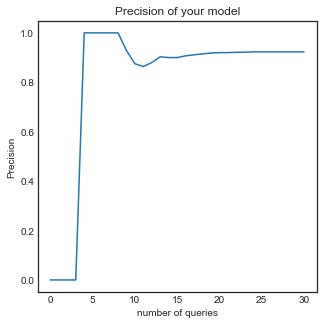

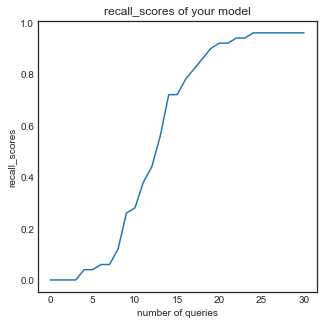

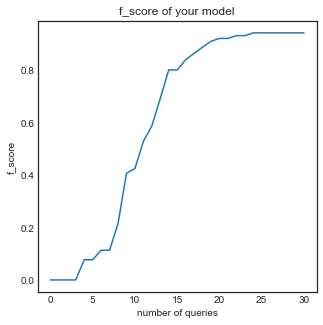

In [96]:
orcl_labels,ams_results_main_no_boot = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = False,
                                        warm= True)

Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/7969191
https://www.airbnb.nl/rooms/728144
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 7969191 == 728144
Name : 2 bedroom apartment in the center of Amsterdam == Beautiful loft in centre of Amsterdam
postalcode : 1017 TV == 1017 LN
Bedrooms : 2.0 == 2.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 4.0
Person_capacity : 4 == 4
Host_first_name : Alexander == Aren
Host_picture_url : https://a0.muscache.com/im/users/26045647/profile_pic/1444149788/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/0eb555cf-75c2-4c3f-873b-d6db6d95b5e7.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36097 == 52.36112
Lng : 4.89445 == 4.8963199999999985
Picture_url : https://a0.muscache.com/im/pictures/11241269-f61c-48a2-b356-1d9cf863cb84.jpg?aki_policy=large == https://a0.muscache.co

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/42065839
https://www.airbnb.nl/rooms/27969251
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 42065839 == 27969251
Name : 'Private Island' in old renovated Coachman's house == Huis Roomolen
postalcode : 1012 VC == 1015 AC
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 4
Host_first_name : Maurits & Willemijn == Henri & Mel
Host_picture_url : https://a0.muscache.com/im/pictures/user/838bd469-ee3d-4920-b919-e6704db7c1eb.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/9e6c7f04-4476-4d01-9880-9ac8d66fb8b6.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37773 == 52.37747
Lng : 4.8929300000000016 == 4.8924699999999985
Picture_url : https://a0.muscache.com/im/pictures/15455b99-a5ee-4cf2-8b00-2bf8f074fcc0.jpg?aki_policy=large == ht

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/575603
https://www.airbnb.nl/rooms/17150944
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 575603 == 17150944
Name : Loft right in the city centre == Perfect Apartment in the Heart of Amsterdam
postalcode : 1017 TT == 1017 VE
Bedrooms : 4.0 == 1.0
Bathrooms : 25.0 == 1.0
Beds : 4.0 == 2.0
Person_capacity : 4 == 4
Host_first_name : Henning == Suzanne
Host_picture_url : https://a0.muscache.com/im/pictures/user/7add6fa8-d6cc-4c69-bd53-b7ae1b41f18a.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/57287982-e786-47e7-a3e4-cff141bdd076.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36112 == 52.36044
Lng : 4.89462 == 4.89438
Picture_url : https://a0.muscache.com/im/pictures/52497575/296a60e8_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/f239d923

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/49790
https://www.airbnb.nl/rooms/4779111
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 49790 == 4779111
Name : Luxurous Houseboat-Great Location == Comfortable and quiet home with a view
postalcode : 1054 XD == 1054 XR
Bedrooms : 2.0 == 2.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 2.0
Person_capacity : 4 == 3
Host_first_name : Klaas == David
Host_picture_url : https://a0.muscache.com/im/users/227530/profile_pic/1283902246/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/24643319/profile_pic/1421411121/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36158 == 52.36121
Lng : 4.86101 == 4.85911
Picture_url : https://a0.muscache.com/im/pictures/1146105/2c19e898_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/308a83b1-b28e-4d10-b0ed-47d6457893e

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/2272303
https://www.airbnb.nl/rooms/12550957
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 2272303 == 12550957
Name : Cosy apartment in De  Pijp bed and breakfast == Great house in centre on ground floor!
postalcode : 1073 CT == 1073 ED
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 15.0
Beds : 5.0 == 2.0
Person_capacity : 4 == 4
Host_first_name : Sonja == Marco
Host_picture_url : https://a0.muscache.com/im/users/11601106/profile_pic/1414168019/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/a5dc95a7-f315-41b2-80c2-ac8a98d19b4c.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35489000000001 == 52.35418
Lng : 4.8973900000000015 == 4.89798
Picture_url : https://a0.muscache.com/im/pictures/b37fd1e7-24fe-45e9-890c-b242145e9794.jpg?aki_policy=large == https://a0.musca

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/28167828
https://www.airbnb.nl/rooms/1603630
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 28167828 == 1603630
Name : The Muyssonette - Jordaan area! == Homesweethomeamsterdam R&C
postalcode : 1015 NA == 1015 DM
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 1.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 2
Host_first_name : Gea == Cido
Host_picture_url : https://a0.muscache.com/im/pictures/user/3b0779e9-308b-49a4-ad2b-df7611855e0b.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/087eb97c-23d1-4406-9f51-74aa1beb5313.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37915 == 52.37886
Lng : 4.88627 == 4.8872300000000015
Picture_url : https://a0.muscache.com/im/pictures/a3623084-40ff-4440-b78e-e60d540ed964.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/2322591

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/27809371
https://www.airbnb.nl/rooms/19854248
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 27809371 == 19854248
Name : The Dutch Suites == Stylish loft with roof terrace in the old center
postalcode : 1012 CJ == 1012 GK
Bedrooms : 2.0 == 2.0
Bathrooms : 1.0 == 15.0
Beds : 2.0 == 2.0
Person_capacity : 4 == 3
Host_first_name : Iris == Yuha
Host_picture_url : https://a0.muscache.com/im/pictures/user/46ef08b8-311c-4758-ae78-892d2ed307c7.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/1a4fcf92-3813-45fa-9d8a-e6f0d32e6581.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37073 == 52.37096
Lng : 4.89635 == 4.89621
Picture_url : https://a0.muscache.com/im/pictures/48dd24f0-1b71-48b7-b5d2-dd988c4a3f63.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/miso/Hos

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/6011262
https://www.airbnb.nl/rooms/29332959
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 6011262 == 29332959
Name : Perfect for IBC **Lovely & sunny on top location** == Olivers Suite: luxury boutique suite in the Pijp
postalcode : 1072 AN == 1072 AP
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 2.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : An == Suzanne
Host_picture_url : https://a0.muscache.com/im/users/31194610/profile_pic/1429016503/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/cf2bc697-053b-47c9-bf8a-3d27fc97f328.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35458 == 52.35422
Lng : 4.886419999999998 == 4.88721
Picture_url : https://a0.muscache.com/im/pictures/78974104/b881efea_original.jpg?aki_policy=large == https://a0.muscache.co

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/877702
https://www.airbnb.nl/rooms/1378074
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 877702 == 1378074
Name : The Weavery Boutique Bed&Breakfast1 == Romantic Design Apartment City Centre
postalcode : 1017 ZX == 1017 TB
Bedrooms : 0.0 == 1.0
Bathrooms : 15.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Driss And Bettina == Andrea
Host_picture_url : https://a0.muscache.com/im/users/4614541/profile_pic/1438101374/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/7356368/profile_pic/1411591555/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36049000000001 == 52.36101
Lng : 4.8898199999999985 == 4.89042
Picture_url : https://a0.muscache.com/im/pictures/4c7c7606-1e0c-4b67-a271-d49d14e45d48.jpg?aki_policy=large == https://a0.muscac

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/53629389
https://www.airbnb.nl/rooms/22394713
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 53629389 == 22394713
Name : Stylish apartment in the heart of City Center! == Lovely studio for 2 in the Red Light District
postalcode : 1012 JT == 1012 LJ
Bedrooms : 2.0 == 0.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Julia == Maikel
Host_picture_url : https://a0.muscache.com/im/pictures/user/ad58fdb8-0726-45d2-988f-6c56590ee680.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/61c0de92-288f-42fa-9c62-e50efe4461cf.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 1 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37502 == 52.37587
Lng : 4.89659 == 4.89766
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-53629389/original/2ef06bed-28de-4aa6-a10b-f8ddefda8bb2.jpeg?aki

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/862411
https://www.airbnb.nl/rooms/22433970
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 862411 == 22433970
Name : Fancy appartement hartje Amsterdam == Lovely apartment in the City Center, Jordaan Area.
postalcode : 1015 JD == 1015 HX
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Simone == Stéphanie
Host_picture_url : https://a0.muscache.com/im/pictures/user/58de598e-0702-4fe5-9edf-de01ec097d87.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/7a3dd02b-5027-45a7-b893-7226918cec84.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.38139 == 52.38115
Lng : 4.88541 == 4.88421
Picture_url : https://a0.muscache.com/im/pictures/16602138/2e6b77f1_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictu

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/7224738
https://www.airbnb.nl/rooms/29046160
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 7224738 == 29046160
Name : Top apartment with garage & outside patio == CITY CENTRE NEAR MUSEUM DISTRICT
postalcode : 1054 BM == 1054 CE
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 2
Host_first_name : Onno == Ric
Host_picture_url : https://a0.muscache.com/im/users/22157201/profile_pic/1436480400/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/389623/profile_pic/1375276781/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36482 == 52.36393
Lng : 4.87474 == 4.8750800000000005
Picture_url : https://a0.muscache.com/im/pictures/d3ccbf16-cb1e-4fce-982a-ce85ad36d242.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/6005b520

1
(25, 99) (25,)
Iteration: 0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/52873992
https://www.airbnb.nl/rooms/52873660
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 52873992 == 52873660
Name : Family Suite | Park Centraal Amsterdam == Junior Suite | Park Centraal Amsterdam
postalcode : 1071 ZD == 1071 ZD
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : nan == nan
Person_capacity : 3 == 3
Host_first_name : Sircle == Sircle
Host_picture_url : https://a0.muscache.com/im/pictures/user/119bdfd7-ee3f-47c9-b121-4aa3a1114ffd.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/119bdfd7-ee3f-47c9-b121-4aa3a1114ffd.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 1 == 1
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.361374 == 52.361374
Lng : 4.883171 == 4.883171
Picture_url : https://a0.muscache.com/im/pictures/prohost-api/Hosting-52873992/original/ab686a02-b761-4ed7-abb4-e1

0
Iteration: 2
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/52891995
https://www.airbnb.nl/rooms/31943477
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 52891995 == 31943477
Name : (A) Cannabis Friendly - The LUX PENTHOUSE -420 == (A) Cannabis Friendly - The Lux First floor -420
postalcode : 1017 PL == 1016 XW
Bedrooms : 2.0 == 2.0
Bathrooms : 15.0 == 1.5
Beds : 2.0 == 3.0
Person_capacity : 4 == 4
Host_first_name : Marcel And Pauline == Marcel And Pauline
Host_picture_url : https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 1 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36479 == 52.36595
Lng : 4.880330000000002 == 4.87982
Picture_url : https://a0.muscache.com/im/pictures/3f474f76-e7ee-482d-ada4-

1
Iteration: 4
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/954633
https://www.airbnb.nl/rooms/954629
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 954633 == 954629
Name : Private apartment for 2 near A'dam Arena == Stylish, clean studio, high service
postalcode : 1102 JG == 1102 JG
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.5
Beds : 2.0 == 2.0
Person_capacity : 2 == 2
Host_first_name : Simone == Simone
Host_picture_url : https://a0.muscache.com/im/users/5183517/profile_pic/1394354526/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/5183517/profile_pic/1394354526/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuidoost == amsterdamzuidoost
Lat : 52.32019 == 52.32019
Lng : 4.95501 == 4.95501
Picture_url : https://a0.muscache.com/im/pictures/6f98344b-5c41-4cac-8f9e-2462c346fe07.jpg?aki_policy=large == https://a0.muscache.com/im/pictur

0
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/1524993
https://www.airbnb.nl/rooms/10046150
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 1524993 == 10046150
Name : Gezellig huis midden in De Jordaan == Treasure in the centre of Amsterdam
postalcode : 1015 SC == 1015 NG
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Yvonne == Alex
Host_picture_url : https://a0.muscache.com/im/pictures/user/8d0a1478-f128-4343-a193-2b052c934f53.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/7bea4b2a-8301-401d-ba94-088c4ef0a045.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37638 == 52.37725
Lng : 4.882

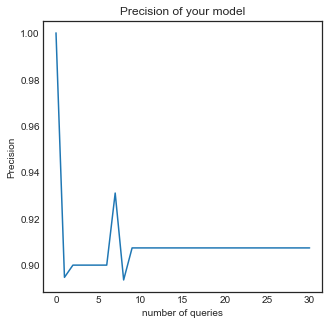

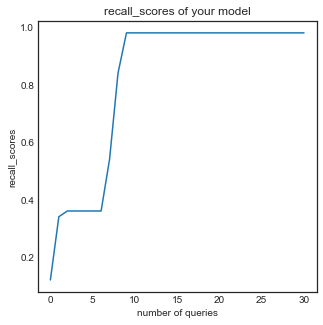

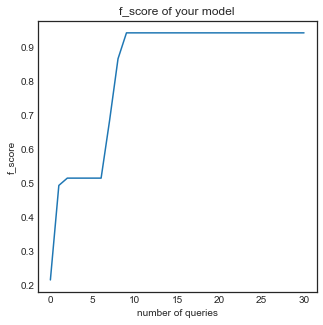

In [98]:
orcl_labels,ams_results_main_no_boot_1 = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = False,
                                        warm= True)

Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/47469046
https://www.airbnb.nl/rooms/14921039
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 47469046 == 14921039
Name : Ruime familiewoning voor gezin met kleine kinderen == Deluxe double room with bathroom incl Breakfast
postalcode : 1022 LA == 1022 KC
Bedrooms : 3.0 == 1.0
Bathrooms : 2.5 == 1.0
Beds : 2.0 == nan
Person_capacity : 4 == 2
Host_first_name : Jeff == Colm
Host_picture_url : https://a0.muscache.com/im/pictures/user/50a25d01-c64d-44e3-8430-23b8872984d6.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/79e28e3c-22b3-41a6-b1f6-61a5a0790a63.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamnoord == amsterdamnoord
Lat : 52.40606 == 52.40611
Lng : 4.93459 == 4.9330300000000005
Picture_url : https://a0.muscache.com/im/pictures/9dee02bf-1520-4bd2-8df8-8fe87cce8de1.jpg?aki_policy=large == https:/

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/48875301
https://www.airbnb.nl/rooms/31731136
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 48875301 == 31731136
Name : Stylish Canal House B == Studio Koggeschip Amsterdam BB
postalcode : 1015 BD == 1015 AB
Bedrooms : 2.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 4.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Rene == Bas-Jan
Host_picture_url : https://a0.muscache.com/im/pictures/user/e8a13d5c-2663-45e1-9966-4c25e40c1808.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/c206f385-5a8f-4f78-ab1c-41c0c763398e.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37734 == 52.3777
Lng : 4.89083 == 4.8922
Picture_url : https://a0.muscache.com/im/pictures/3a1ccc01-21e4-4e7c-8ec5-5bc67f6216af.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/6e235acc-7e18-4a0e-8a

1
(4, 99) (4,)
Iteration: 0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/46348181
https://www.airbnb.nl/rooms/46348037
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 46348181 == 46348037
Name : Rembrandt Studio Two == Rembrandt Studio One
postalcode : 1012 AC == 1017 AB
Bedrooms : 0.0 == 0.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Rob & Anouk == Rob & Anouk
Host_picture_url : https://a0.muscache.com/im/pictures/user/9aeab941-d550-4003-8a48-788b61f9de0a.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/9aeab941-d550-4003-8a48-788b61f9de0a.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36729 == 52.36722
Lng : 4.8939 == 4.89531
Picture_url : https://a0.muscache.com/im/pictures/b261af20-b5da-49e6-af2e-7fa3ecd8d34d.jpg?aki_policy=large == https://a0.muscache.com/im/pic

1
Iteration: 2
Iteration: 3
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/7597331
https://www.airbnb.nl/rooms/20488828
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 7597331 == 20488828
Name : Cosy apartment with lift in trendy Amsterdam West! == Cosy canal view apartment in Old West Amsterdam
postalcode : 1058 AA == 1058 DE
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 15.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Carola == Wouter
Host_picture_url : https://a0.muscache.com/im/pictures/user/8979db77-4c9b-4d0c-bbef-7755d5196f7f.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/7c458860-771b-4eec-9947-51c5ec61e21b.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36398 == 52.36383
Lng : 4.85847 == 4.85654
Picture_url : https://a0.muscache.com/im/pictures/fe3cc29a-30e0-4c18-ac06-4081423b9970.jpg?aki_polic

0
Iteration: 5
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/24097052
https://www.airbnb.nl/rooms/23558784
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 24097052 == 23558784
Name : Spacious room- quiet neighbourhood- free parking x == 2-Person Balcony Room + FreeParking x
postalcode : 1060 RX == 1060 RT
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Klaas == Klaas
Host_picture_url : https://a0.muscache.com/im/pictures/user/d3287dd3-8ae6-4194-92ad-856e5c638914.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/d3287dd3-8ae6-4194-92ad-856e5c638914.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdam nieuwwest == amsterdam nieuwwest
Lat : 52.348 == 52.34778
Lng : 4.78792 == 4.7880699999999985
Picture_url : https://a0.muscache.com/im/pictures/e2cfa10f-4605-4321-9628-2b788a0891ac.jpg?aki_policy=l

1
Iteration: 7
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/9103703
https://www.airbnb.nl/rooms/760074
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 9103703 == 760074
Name : Cosy apartment near city center == Nice Apartment 50m2, East Side!
postalcode : 1094 HT == 1094 AS
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 1.0 == nan
Person_capacity : 2 == 2
Host_first_name : Erwin == Dorien
Host_picture_url : https://a0.muscache.com/im/pictures/user/e8165298-e1b9-477d-8fae-c4211f2ede86.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/3661217/profile_pic/1351530416/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.36417 == 52.36501
Lng : 4.93963 == 4.93792
Picture_url : https://a0.muscache.com/im/pictures/ad8c700b-59f8-478b-bed0-215b0c55c403.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/miso/Hosting

1
Iteration: 9
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/26071272
https://www.airbnb.nl/rooms/25391426
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 26071272 == 25391426
Name : Perfect Double Room Ams WTC-Zuid (shared Bathroom) == Fantastic Loft-Penthouse in Amsterdam South !!
postalcode : 1076 LD == 1076 KJ
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Thierry == Thierry
Host_picture_url : https://a0.muscache.com/im/pictures/user/3d5efaef-d0dc-44e3-b0b2-18394353f0ce.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/3d5efaef-d0dc-44e3-b0b2-18394353f0ce.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.3452 == 52.344
Lng : 4.86311 == 4.86365
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-26071272/original/56c61cb6-a61e-47ee-851f-adc867465

1
Iteration: 12
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/5663570
https://www.airbnb.nl/rooms/35145947
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 5663570 == 35145947
Name : Canal view apartment by superhost == Beautiful light and spacious house in the centre.
postalcode : 1015 WV == 1015 ZJ
Bedrooms : 1.0 == 5.0
Bathrooms : 1.5 == 2.0
Beds : 1.0 == 5.0
Person_capacity : 2 == 10
Host_first_name : Menno == Jelle
Host_picture_url : https://a0.muscache.com/im/users/29360280/profile_pic/1426415525/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/6764968/profile_pic/1370502591/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37628 == 52.37647
Lng : 4.87766 == 4.87705
Picture_url : https://a0.muscache.com/im/pictures/722b6506-4d88-44c1-af09-30244cce2ee0.jpg?aki_policy=large == https://a0.muscache.c

0
Iteration: 14
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/2871016
https://www.airbnb.nl/rooms/1677381
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 2871016 == 1677381
Name : Spacious loft appartment in center of Jordaan area == Exclusieve privékamer Keizersgracht
postalcode : 1015 GC == 1013 GZ
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Christophe == Jillis & Cristina
Host_picture_url : https://a0.muscache.com/im/users/14674897/profile_pic/1398350224/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/8873574/profile_pic/1379359615/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.38009 == 52.3798
Lng : 4.88874 == 4.89058
Picture_url : https://a0.muscache.com/im/pictures/955efb01-682e-48e6-a921-5bff6060ac0e.jpg?aki_policy=large == https

0
Iteration: 16
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/37901569
https://www.airbnb.nl/rooms/23054732
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 37901569 == 23054732
Name : Spacious & lovely apartment in hip area Amsterdam == Luxury Amsterdam apartment with XL rooftop terrace
postalcode : 1094 AN == 1094 AV
Bedrooms : 2.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : 3.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Maria == Ivo
Host_picture_url : https://a0.muscache.com/im/users/2299141/profile_pic/1366743006/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/13338413/profile_pic/1429555674/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.36536 == 52.3649
Lng : 4.9376 == 4.93741
Picture_url : https://a0.muscache.com/im/pictures/3ebf90b1-2132-41ea-95b0-98939b87883c.jpg?aki_policy=large == https://a0.mu

0
Iteration: 18
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/2761156
https://www.airbnb.nl/rooms/14218726
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 2761156 == 14218726
Name : Comfortable sky room2 12th floor == Sky Room Amsterdam
postalcode : 1058 EM == 1058 EM
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 15.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Rick == Rick
Host_picture_url : https://a0.muscache.com/im/pictures/user/916415ab-d6b0-4ff7-a4fc-d26311716367.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/916415ab-d6b0-4ff7-a4fc-d26311716367.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdam nieuwwest == amsterdam nieuwwest
Lat : 52.36309 == 52.36309
Lng : 4.84393 == 4.84393
Picture_url : https://a0.muscache.com/im/pictures/620e4e45-9831-4be5-8f1e-60bab6b57a39.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/0f40

0
Iteration: 21
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/20840176
https://www.airbnb.nl/rooms/16197533
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 20840176 == 16197533
Name : 10 double cabins on sailing ship, 20 min to center == Double cabin on sailing ship 20 min to center No 4
postalcode : 1087 HM == 1087 HJ
Bedrooms : 10.0 == 1.0
Bathrooms : 3.0 == 35.0
Beds : 20.0 == 2.0
Person_capacity : 16 == 2
Host_first_name : Wamme == Wamme
Host_picture_url : https://a0.muscache.com/im/pictures/user/a59d0c43-d2c7-4555-a8d4-f73b4de6c5e4.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/a59d0c43-d2c7-4555-a8d4-f73b4de6c5e4.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.35498 == 52.35486
Lng : 5.00602 == 5.00437
Picture_url : https://a0.muscache.com/im/pictures/3c7a27d7-e893-4282-9c3c-0cbe0ccab5c9.jpg?aki_policy=larg

1
Iteration: 23
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/6619931
https://www.airbnb.nl/rooms/6356312
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 6619931 == 6356312
Name : 4 bedroom family apartment near De Hallen == Great spacious house with rooftop
postalcode : 1053 TT == 1053 ST
Bedrooms : 4.0 == 2.0
Bathrooms : 2.0 == 3.0
Beds : 3.0 == 4.0
Person_capacity : 4 == 4
Host_first_name : Roos == Marijn
Host_picture_url : https://a0.muscache.com/im/users/6207685/profile_pic/1433361730/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/10390341/profile_pic/1431357740/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36866 == 52.3682
Lng : 4.8680400000000015 == 4.86603
Picture_url : https://a0.muscache.com/im/pictures/a426cf4d-ac61-49b1-96fa-37f075728d6a.jpg?aki_policy=large == https://a0.muscache.com/im/p

0
Iteration: 27
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/4743636
https://www.airbnb.nl/rooms/32735585
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 4743636 == 32735585
Name : Room in a charming old grachtenhouse (32) == Cosy Prinsengracht Canal view private room
postalcode : 1017 DZ == 1017 VL
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Hans == Willem
Host_picture_url : https://a0.muscache.com/im/users/24002310/profile_pic/1416584334/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/34561008/profile_pic/1432975527/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36425 == 52.36336
Lng : 4.89931 == 4.89939
Picture_url : https://a0.muscache.com/im/pictures/d000b765-4149-4d26-92ac-11389a0bf2f5.jpg?aki_policy=large == https://a0.muscache.

0


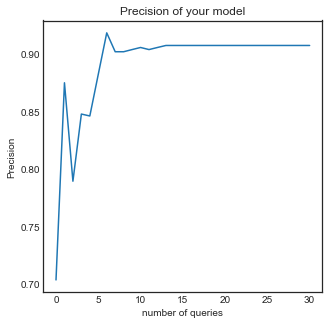

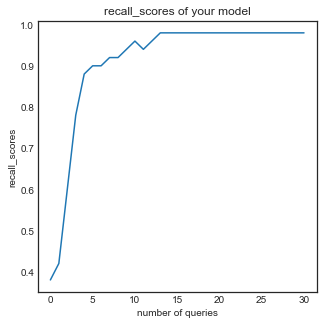

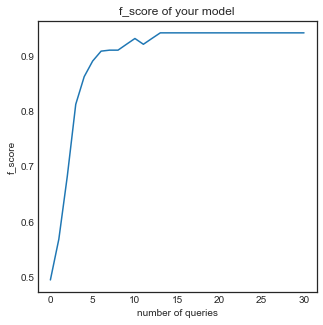

In [101]:
orcl_labels,ams_results_main_no_boot_2 = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = False,
                                        warm= True)

Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/1766570
https://www.airbnb.nl/rooms/16235797
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 1766570 == 16235797
Name : Rembrandt van Rijn apartment canal view == Modern canal-district residence
postalcode : 1017 EN == 1017 GC
Bedrooms : 2.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 4 == 4
Host_first_name : Anja == Kerkstraat B&B
Host_picture_url : https://a0.muscache.com/im/pictures/user/17e7221f-1970-434b-a76e-9240d8034888.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/6adec273-c861-44ae-9cd9-8526c7fb3dca.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.3643 == 52.36468
Lng : 4.8886699999999985 == 4.88678
Picture_url : https://a0.muscache.com/im/pictures/01d09e0f-47c9-4af4-ae5f-6396e3b608dc.jpg?aki_policy=large == https://a0.muscache.com

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/43254740
https://www.airbnb.nl/rooms/30394912
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 43254740 == 30394912
Name : Cozy room Mercedesbnb Amsterdam center == New! Exclusive Houseboat "Bluewater  Amsterdam".
postalcode : 1015 KJ == 1015 KJ
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 2.5
Beds : 1.0 == 1.0
Person_capacity : 2 == 4
Host_first_name : Isabel == Suzanne
Host_picture_url : https://a0.muscache.com/im/pictures/user/8e1cb1e1-92d5-4571-ac41-ad8754ab7e5e.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/059a037f-b067-4c57-93b7-a1d47e4438a4.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.38066 == 52.38075
Lng : 4.88726 == 4.88625
Picture_url : https://a0.muscache.com/im/pictures/ace6f140-2471-45be-9fdf-6fc4ed4a9492.jpg?aki_policy=large == https://a0.muscach

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/5390933
https://www.airbnb.nl/rooms/15304003
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 5390933 == 15304003
Name : Historic-Central Canal House-6 room == Luxury houseboat in Amsterdam Centre! ( 3br 110m²)
postalcode : 1011 KW == 1011 GK
Bedrooms : 5.0 == 3.0
Bathrooms : 2.5 == 2.0
Beds : 6.0 == 3.0
Person_capacity : 6 == 4
Host_first_name : Heidi == Robert
Host_picture_url : https://a0.muscache.com/im/users/11929685/profile_pic/1391522876/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/7a8ca7a7-97a7-47eb-b47d-f93de0b42b9d.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37088 == 52.37145
Lng : 4.90351 == 4.90164
Picture_url : https://a0.muscache.com/im/pictures/81135348/ce8baf50_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/m

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/30933786
https://www.airbnb.nl/rooms/19991681
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 30933786 == 19991681
Name : Light and spacious appartment Westerpark == Modern design one-bedroom apt! Great location!
postalcode : 1051 PR == 1051 CC
Bedrooms : 2.0 == 1.0
Bathrooms : 15.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Jelle == Astrid
Host_picture_url : https://a0.muscache.com/im/pictures/user/1236821f-7fc7-4904-82ef-b262ca0fd0b1.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/45655021/profile_pic/1443880218/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.38236 == 52.38232
Lng : 4.86899 == 4.86988
Picture_url : https://a0.muscache.com/im/pictures/29245416-fb99-4568-a5bd-378777005285.jpg?aki_policy=large == https://a0.muscache.com/im/pi

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/31945182
https://www.airbnb.nl/rooms/10198226
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 31945182 == 10198226
Name : Small Twin Ensuite == NICE PRIVE ROOM IN RED LIGHT STREET in top floor
postalcode : 1012 JA == 1012 GX
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 1.0 == 4.0
Person_capacity : 2 == 4
Host_first_name : St Christophers At The Winston == Zidan
Host_picture_url : https://a0.muscache.com/im/pictures/user/59f6aec2-6654-4008-99df-520ddedf78aa.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/37463467/profile_pic/1436658354/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37392 == 52.37418
Lng : 4.89635 == 4.89823
Picture_url : https://a0.muscache.com/im/pictures/a6d9b2aa-0a0d-462b-a00a-5bd382514721.jpg?aki_policy=large == https://a0.muscache.

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/4225575
https://www.airbnb.nl/rooms/38425685
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 4225575 == 38425685
Name : Privé verblijf op luxe woonschip vlakbij centrum == Luxury Houseboat -  Romantic getaway!
postalcode : 1013 CR == 1013 PH
Bedrooms : 2.0 == 0.0
Bathrooms : 1.0 == 1.5
Beds : 3.0 == nan
Person_capacity : 4 == 2
Host_first_name : Laura En Rene == Sjoerd
Host_picture_url : https://a0.muscache.com/im/pictures/user/3b1a7b4b-4b12-486e-ab19-5ca9091014b7.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/93e59015-ae28-4e64-ae70-2264f3fd1ff1.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.39038 == 52.38954
Lng : 4.88716 == 4.88641
Picture_url : https://a0.muscache.com/im/pictures/b41e905d-0232-4f85-9d41-b8ffd7396219.jpg?aki_policy=large == https://a0.muscache.c

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/23971504
https://www.airbnb.nl/rooms/12840460
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 23971504 == 12840460
Name : Cosy, Private, Canal view, Museum area, stylish. == Romantic Canalside Apt, Museum Distr. Top location
postalcode : 1071 TV == 1071 VW
Bedrooms : 0.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Ellen == Ozlem
Host_picture_url : https://a0.muscache.com/im/pictures/user/cf44957a-b2cc-4975-a800-68d851c11aa0.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/339550f0-c6bb-4a38-a7c1-b1587b9b6601.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35254000000001 == 52.35351
Lng : 4.88516 == 4.88529
Picture_url : https://a0.muscache.com/im/pictures/374673bf-bed1-41bb-89cf-e09911dc6f02.jpg?aki_policy=large == https:

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/31051752
https://www.airbnb.nl/rooms/22738244
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 31051752 == 22738244
Name : Lovely 1 bedroom accommodation. Central Area == Spacious apartment & fantastic roof top
postalcode : 1051 GX == 1051 LC
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 3
Host_first_name : Olga == Tjalle
Host_picture_url : https://a0.muscache.com/im/pictures/user/0d8ca5ab-77f4-4ba8-a065-c4c2bff904b1.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/009e3874-1ac5-4155-858c-9d232755448e.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.38431 == 52.38512
Lng : 4.87016 == 4.87079
Picture_url : https://a0.muscache.com/im/pictures/03e4836b-1054-4f81-b89f-4e062de9700f.jpg?aki_policy=large == https://a0.muscache.com/im/pic

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/7213232
https://www.airbnb.nl/rooms/2818
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 7213232 == 2818
Name : Calm, spacious room in vibrant area == Quiet Garden View Room & Super Fast WiFi
postalcode : 1095 TE == 1095 XC
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 1.0 == 2.0
Person_capacity : 2 == 2
Host_first_name : Yannick == Daniel
Host_picture_url : https://a0.muscache.com/im/users/1272887/profile_pic/1318273252/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/3159/profile_pic/1259095323/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.36382 == 52.36435
Lng : 4.94345 == 4.94358
Picture_url : https://a0.muscache.com/im/pictures/104361167/38f5afc9_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/10272854/8dcca016_original.jpg?

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/937635
https://www.airbnb.nl/rooms/29174186
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 937635 == 29174186
Name : The A'dam experience! Spacious Loft == Cozy apartment near Vondelpark and city center
postalcode : 1054 MH == 1054 VV
Bedrooms : 3.0 == 2.0
Bathrooms : 1.0 == 1.0
Beds : 4.0 == 2.0
Person_capacity : 5 == 4
Host_first_name : Leontine == Li
Host_picture_url : https://a0.muscache.com/im/users/5062046/profile_pic/1368779336/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/61d8bd3a-a429-48bc-9234-c383cda0eb40.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36246 == 52.36218
Lng : 4.86411 == 4.86589
Picture_url : https://a0.muscache.com/im/pictures/19318518/79a376d1_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/23c538d7-8bea-4

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/48008046
https://www.airbnb.nl/rooms/48005116
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 48008046 == 48005116
Name : Residences | 1-Bedrooms | Serviced Apartment == Residences | 4-Bedrooms | Serviced Apartment
postalcode : 1072 LK == 1072 LK
Bedrooms : 1.0 == 4.0
Bathrooms : 1.5 == 3.0
Beds : 3.0 == 8.0
Person_capacity : 4 == 8
Host_first_name : Residences == Residences
Host_picture_url : https://a0.muscache.com/im/pictures/user/0ec6c665-603a-4b3e-a88f-e963caca4030.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/0ec6c665-603a-4b3e-a88f-e963caca4030.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdam == amsterdam
Lat : 52.35708 == 52.35712
Lng : 4.89113 == 4.89098
Picture_url : https://a0.muscache.com/im/pictures/13a1691b-e86e-4f79-8347-562747085ce7.jpg?aki_policy=large == https://a0.muscache.com

1
Iteration: 1
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/41710225
https://www.airbnb.nl/rooms/41336570
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 41710225 == 41336570
Name : Standard Double Ensuite == Premium Double Ensuite
postalcode : 1012 JA == 1012 JA
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : St Christophers At The Winston == St Christophers At The Winston
Host_picture_url : https://a0.muscache.com/im/pictures/user/59f6aec2-6654-4008-99df-520ddedf78aa.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/59f6aec2-6654-4008-99df-520ddedf78aa.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37392 == 52.37392
Lng : 4.89635 == 4.89635
Picture_url : https://a0.muscache.com/im/pictures/7f4f599c-de07-4e32-98fd-e2acdf354848.jpg?aki_policy=large ==

1
Iteration: 3
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/3902098
https://www.airbnb.nl/rooms/16204076
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 3902098 == 16204076
Name : Cosy, Classic Sailing Ship "de Lis" == Double cabin on sailing ship 20 min to center No 7
postalcode : 1087 HW == 1087 HW
Bedrooms : 6.0 == 1.0
Bathrooms : 1.0 == 3.0
Beds : 12.0 == 2.0
Person_capacity : 12 == 2
Host_first_name : Leon == Wamme
Host_picture_url : https://a0.muscache.com/im/pictures/user/de4f6e2d-1968-40ed-a597-beb761a0ebb1.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/a59d0c43-d2c7-4555-a8d4-f73b4de6c5e4.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.3536 == 52.35364000000001
Lng : 5.0062 == 5.00649
Picture_url : https://a0.muscache.com/im/pictures/49092238/5f7671b6_original.jpg?aki_policy=large == https://a0.muscache

0
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/8694687
https://www.airbnb.nl/rooms/31050856
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 8694687 == 31050856
Name : Central Canalside Design B&B Dream House Of Swings == Amsterdam centrum - Jordaan apartment Canal view
postalcode : 1051 AW == 1051 AK
Bedrooms : 1.0 == 3.0
Bathrooms : 1.5 == 15.0
Beds : 1.0 == 5.0
Person_capacity : 2 == 4
Host_first_name : Gabriella == Joost
Host_picture_url : https://a0.muscache.com/im/pictures/user/734b5471-a0ea-4e3a-a96a-874319a74dc6.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/37806139/profile_pic/1436348105/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.38385 == 52.38319
Lng : 4.8775900000000005 == 4.8765839999999985
Picture_url : https://a0.muscache.com

1
Iteration: 14
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/613088
https://www.airbnb.nl/rooms/3155284
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 613088 == 3155284
Name : Your own cottage in the countryside == Your cottage in the countryside
postalcode : 1027 AE == 1027 AE
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Henk == Henk
Host_picture_url : https://a0.muscache.com/im/users/3040748/profile_pic/1352910136/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/3040748/profile_pic/1352910136/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamnoord == amsterdamnoord
Lat : 52.41016 == 52.41016
Lng : 4.96369 == 4.96369
Picture_url : https://a0.muscache.com/im/pictures/7764816/a5c4c90b_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/40205210/b376cf1f_origin

1
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/53401296
https://www.airbnb.nl/rooms/52855807
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 53401296 == 52855807
Name : HIGHLY LUXURIOUS & FANCY 7-star apartment in City == Luxe studio in het centrum van Amsterdam aan de Leidsegracht
postalcode : 1017 RP == 1017 PT
Bedrooms : 1.0 == 0.0
Bathrooms : 15.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 3 == 2
Host_first_name : Mehrdad == Tamara - BELVILLA
Host_picture_url : https://a0.muscache.com/im/pictures/user/cd427cb8-4f86-439b-a235-de50db0aca76.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/d337bda2-1841-47bc-8de3-1702898dcff8.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 1 == 1
Neighborhood : amsterdamcentrum == amsterdam

1


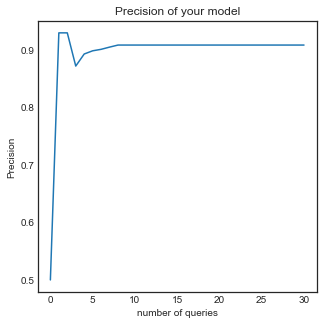

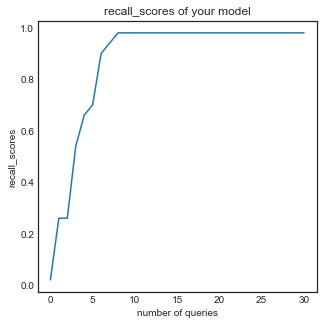

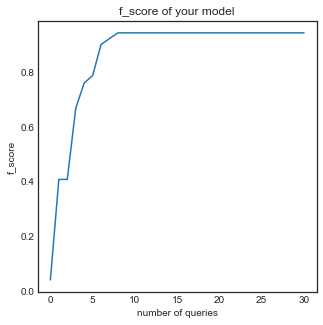

In [104]:
orcl_labels,ams_results_main_no_boot_3 = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = False,
                                        warm= True)

Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/42743643
https://www.airbnb.nl/rooms/33303727
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 42743643 == 33303727
Name : Pestana Amsterdam Riverside, Executive == Luxury Apartment for 2 in authentic 'de Pijp'
postalcode : 1074 VM == 1074 TW
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : nan == 1.0
Person_capacity : 2 == 2
Host_first_name : Pestana Amsterdam Riverside == Boy
Host_picture_url : https://a0.muscache.com/im/pictures/user/e052af75-f25b-4514-8bc1-843612be8616.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/a308085d-29e8-45d0-926b-3ea97fa1b5a2.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35276 == 52.35203
Lng : 4.90604 == 4.90514
Picture_url : https://a0.muscache.com/im/pictures/95b53ade-01f0-4217-8827-71e19a7b3a44.jpg?aki_policy=large == https://a0.m

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/818085
https://www.airbnb.nl/rooms/24733482
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 818085 == 24733482
Name : La Vie En Rose B&B Amsterdam Centrum Suite 2 == Single City Centre
postalcode : 1012 VD == 1012 TS
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 1
Host_first_name : Christa & Yvon == Jacqueline
Host_picture_url : https://a0.muscache.com/im/pictures/user/c8396850-010a-4089-99ee-4c096abfd1b5.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/95d82098-5b63-4947-8104-a59b35b19dd5.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.3767 == 52.37725
Lng : 4.8919 == 4.8937300000000015
Picture_url : https://a0.muscache.com/im/pictures/ec3df0ae-3d9d-43a3-b1d3-e395257a6b7f.jpg?aki_policy=large == https://a0.muscache.com/im

0
(5, 99) (5,)
Iteration: 0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/9181640
https://www.airbnb.nl/rooms/7523012
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 9181640 == 7523012
Name : Nice apartment in center of Amsterdam == Cosy apartment in center of Amsterdam
postalcode : 1052 LN == 1052 LN
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == nan
Person_capacity : 2 == 2
Host_first_name : Jesse == Jesse
Host_picture_url : https://a0.muscache.com/im/users/23060282/profile_pic/1444402506/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/23060282/profile_pic/1444402506/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.37239 == 52.37239
Lng : 4.87172 == 4.87172
Picture_url : https://a0.muscache.com/im/pictures/38a01daa-0234-47d5-a107-27ac42c72ef6.jpg?aki_policy=large == https://a0.muscache.com/i

1
Iteration: 2
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/6077424
https://www.airbnb.nl/rooms/25133928
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 6077424 == 25133928
Name : Charming house in Museum Quarter == Amsterdam home with garden
postalcode : 1071 WR == 1071 VH
Bedrooms : 4.0 == 2.0
Bathrooms : 3.0 == 15.0
Beds : 4.0 == 3.0
Person_capacity : 6 == 5
Host_first_name : Dijana == Annika
Host_picture_url : https://a0.muscache.com/im/users/21168948/profile_pic/1431905884/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/24255814/profile_pic/1426093849/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35307 == 52.35253
Lng : 4.88131 == 4.8829400000000005
Picture_url : https://a0.muscache.com/im/pictures/80761571/790b82d8_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/4f99e847-2e5

1
Iteration: 4
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/53286589
https://www.airbnb.nl/rooms/26489486
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 53286589 == 26489486
Name : 1 bedroom apartment right by Vondelpark, Amsterdam == Central, sunny apartment in Oud-West, Amsterdam
postalcode : 1054 ML == 1054 MX
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Róman == Nick
Host_picture_url : https://a0.muscache.com/im/pictures/user/4a98d382-cb9d-4173-9c82-c77016a72409.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/30c20aaf-05b8-4e78-832c-651fee998ffa.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 1 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.361086479156704 == 52.36181
Lng : 4.86472847462937 == 4.8653900000000005
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-53286589/original/f746

0
Iteration: 6
Iteration: 7
Iteration: 8
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/9292601
https://www.airbnb.nl/rooms/20118492
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 9292601 == 20118492
Name : Simple and hip appartment == Light and spacious apartment next to city center
postalcode : 1056 PG == 1056 CR
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Jeroen == Inge
Host_picture_url : https://a0.muscache.com/im/users/5020644/profile_pic/1360398830/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/45f41315-630e-49fa-8c77-f3e3edf8673a.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.37085 == 52.372
Lng : 4.84896 == 4.84921
Picture_url : https://a0.muscache.com/im/pictures/ddce59ed-72d2-4b82-b631-174e1d425a01.jpg?aki_policy=large == https://a0

0
Iteration: 11
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/51950666
https://www.airbnb.nl/rooms/45169008
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 51950666 == 45169008
Name : (A) Cannabis Friendly - The Lux 2nd floor -420 == Cannabis Friendly Weber Design Studio 5
postalcode : 1017 PL == 1017 PJ
Bedrooms : 2.0 == 0.0
Bathrooms : 1.0 == 1.0
Beds : 3.0 == nan
Person_capacity : 4 == 2
Host_first_name : Marcel And Pauline == Marcel And Pauline
Host_picture_url : https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 1 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.364788 == 52.36497
Lng : 4.880334 == 4.88061
Picture_url : https://a0.muscache.com/im/pictures/cf90e9ec-54f6-4a5e-9dcd-aeb33e50310b.jpg?

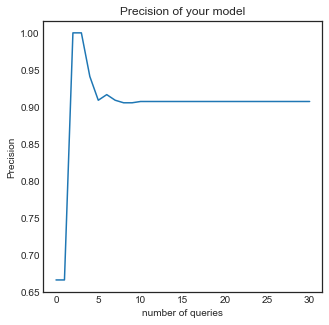

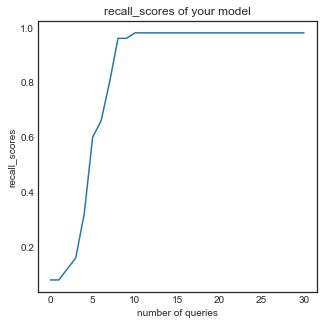

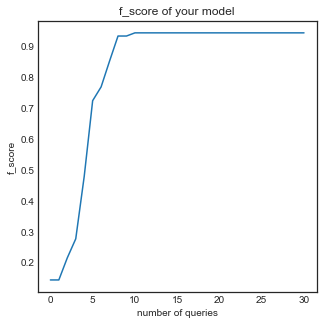

In [106]:
orcl_labels,ams_results_main_no_boot_4 = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = False,
                                        warm= True)

In [174]:
resuts_noboot_ams = [ams_results_main_no_boot_4,ams_results_main_no_boot_3,ams_results_main_no_boot_2
                     ,ams_results_main_no_boot_1,ams_results_main_no_boot]

file_name = "resuts_noboot_ams.pkl"

open_file = open(file_name, "wb")
pickle.dump(resuts_noboot_ams, open_file)
open_file.close()

In [107]:
#Take out the labeled data for making a test set 
manual_labeled = []

for (tuple_1,tuple_2),label in orcl_labels:
    if label ==2 :
        manual_labeled.append([str((tuple_1,tuple_2)),np.float('nan')])
        manual_labeled.append([str((tuple_2,tuple_1)),np.float('nan')])
    else:    
        manual_labeled.append([str((tuple_1,tuple_2)),label])
        manual_labeled.append([str((tuple_2,tuple_1)),label])

#Save the labeled data into the main dataframe
for tuples,label in manual_labeled:
    df_ams_train['label'][df_ams_train['ids']== tuples] = label

Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/52712134
https://www.airbnb.nl/rooms/311124
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 52712134 == 311124
Name : Characteristic and stylish apartment in de Jordaan == *in historic centre *Jordaan *bright  *canal view
postalcode : 1016 VV == 1016 VW
Bedrooms : 2.0 == 1.0
Bathrooms : 15.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Vivian == Anke & Robert
Host_picture_url : https://a0.muscache.com/im/pictures/user/584a9830-0ff9-43b0-8465-7669cc339afd.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/1600010/profile_pic/1364046747/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 1 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.3714 == 52.37104
Lng : 4.87685 == 4.87713
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-52712134/original/c2889159-c061-47fd-9afd-1e89037c608a.jpe

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/44423940
https://www.airbnb.nl/rooms/31100723
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 44423940 == 31100723
Name : ? Luxurious, boutique canal view apartment with balcony next to Albert Cuyp Market == Cosy apartment in "De Pijp"
postalcode : 1073 BX == 1073 BP
Bedrooms : 2.0 == 2.0
Bathrooms : 2.0 == 1.0
Beds : 2.0 == 2.0
Person_capacity : 4 == 3
Host_first_name : Pauline == Rebecca
Host_picture_url : https://a0.muscache.com/im/pictures/user/fc2398f9-9cbb-4a68-b085-fd9523a41154.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/16828309/profile_pic/1402868739/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35638 == 52.35666
Lng : 4.89809 == 4.89785
Picture_url : https://a0.muscache.com/im/pictures/2ff80f40-237b-4656-a9f0-0484394f3af5.jpg?aki_policy=large == http

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/2469007
https://www.airbnb.nl/rooms/12526625
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 2469007 == 12526625
Name : Unique roofterrace Penthouse, no cleaning costs == Sunny Studio (groundfloor)
postalcode : 1053 WE == 1053 VA
Bedrooms : 2.0 == 1.0
Bathrooms : 1.5 == 1.5
Beds : 2.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Tom == Boely&Martine
Host_picture_url : https://a0.muscache.com/im/pictures/user/d8a2d71c-fd1f-42b5-9ece-cea2ab7ece30.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/817af28d-ea87-4273-ad1c-cf8de27db7e2.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36948 == 52.37016
Lng : 4.86822 == 4.86902
Picture_url : https://a0.muscache.com/im/pictures/b743ae29-8e3b-474e-87fe-8414bbc4ab47.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/3492282
https://www.airbnb.nl/rooms/32691009
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 3492282 == 32691009
Name : Nice apartment in Helmersbuurt == Great apartment in City Center Amsterdam
postalcode : 1053 XH == 1053 ML
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 15.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 4
Host_first_name : Karlijn == Lois
Host_picture_url : https://a0.muscache.com/im/users/669137/profile_pic/1399921401/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/b2aed5b9-f1d3-4b9c-9a0b-7a60d8d217cf.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36682 == 52.36582
Lng : 4.87356 == 4.87371
Picture_url : https://a0.muscache.com/im/pictures/4a5047e0-0d52-4db9-b036-3958f28ebb8f.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/aeabbc08-df40

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/47810074
https://www.airbnb.nl/rooms/1041309
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 47810074 == 1041309
Name : Comfortable Deluxe Room - Amsterdam Center == Rijksmuseum/Vondelpark - dakterras
postalcode : 1071 XA == 1071 BE
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 1.0 == 2.0
Person_capacity : 3 == 2
Host_first_name : Reservations == Martine
Host_picture_url : https://a0.muscache.com/im/pictures/user/710246d1-b5c6-497f-872f-570d0659b55e.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/96bf889b-3e47-4f17-b62a-b57061d836ad.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35371 == 52.3543
Lng : 4.88281 == 4.88103
Picture_url : https://a0.muscache.com/im/pictures/71129489-25a7-4856-af56-ffc7c81d81f0.jpg?aki_policy=large == https://a0.muscache.com/im/pict

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/46374246
https://www.airbnb.nl/rooms/31453479
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 46374246 == 31453479
Name : ???? CANAL APARTMENT | AMSTERDAM CENTRAL | 4P ???? == b&b einstein was here amsterdam centrum albert II
postalcode : 1018 VW == 1018 VG
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Eva & Kobe == Claartje
Host_picture_url : https://a0.muscache.com/im/pictures/user/2df702a0-b346-4dae-b860-c11b0998703d.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/9968b43d-e51e-433f-86da-81511d182b10.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36397 == 52.36469
Lng : 4.91033 == 4.90974
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-46374246/original/fb42dcae-f1e6-4738-9a2a-d1caa8

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/4591192
https://www.airbnb.nl/rooms/44280700
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 4591192 == 44280700
Name : VERY PRIVATE: The Hidden House == Private modern apartment in De Pijp.
postalcode : 1074 XZ == 1074 HS
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.5
Beds : 2.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Renée == Rose
Host_picture_url : https://a0.muscache.com/im/pictures/user/4e8712aa-9059-4e18-8196-8a28c7cbeefe.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/607627cb-3474-42ab-9bef-facb7ff3b132.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35643 == 52.35683
Lng : 4.90409 == 4.90425
Picture_url : https://a0.muscache.com/im/pictures/1940a0e1-1e35-4016-9956-f6adcdb3226b.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/5c2d63c6-815c-

1
(15, 93) (15,)
Iteration: 0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/33733808
https://www.airbnb.nl/rooms/16203297
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 33733808 == 16203297
Name : Double cabin on sailing ship 20 min to center No 9 == Double cabin on sailing ship 20 min to center No 1
postalcode : 1087 HT == 1087 HV
Bedrooms : 1.0 == 1.0
Bathrooms : 35.0 == 3.0
Beds : 2.0 == 2.0
Person_capacity : 2 == 2
Host_first_name : Wamme == Wamme
Host_picture_url : https://a0.muscache.com/im/pictures/user/a59d0c43-d2c7-4555-a8d4-f73b4de6c5e4.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/a59d0c43-d2c7-4555-a8d4-f73b4de6c5e4.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.3526 == 52.35324
Lng : 5.005330000000002 == 5.0044
Picture_url : https://a0.muscache.com/im/pictures/c4e5fa46-089f-4c61-9921-59db91e74baa.

1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/32235074
https://www.airbnb.nl/rooms/32234710
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 32235074 == 32234710
Name : Wittenberg Two Bedroom Superior Apartment == Wittenberg Two Bedroom Apartment
postalcode : 1018 TM == 1018 VG
Bedrooms : 1.0 == 1.0
Bathrooms : 2.0 == 2.0
Beds : 2.0 == 2.0
Person_capacity : 4 == 2
Host_first_name : Wittenberg == Wittenberg
Host_picture_url : https://a0.muscache.com/im/pictures/user/fb79a2a5-ea38-4539-b7d1-9d0818f6670b.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/fb79a2a5-ea38-4539-b7d1-9d0818f6670b.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36594 == 52.36575
Lng : 4.91037 == 4.90896
Picture_url : https://a0.muscache.com/im/pictures/72e79b1d-c78d-4490-86fc-0cfe16d78

1
Iteration: 7
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/42288239
https://www.airbnb.nl/rooms/42241245
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 42288239 == 42241245
Name : Lovely room for two close to Amstel river == Room for up to three people near Amstel river in great area
postalcode : 1096 AM == 1096 AM
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : 2.0 == 2.0
Person_capacity : 2 == 3
Host_first_name : Peter == Peter
Host_picture_url : https://a0.muscache.com/im/pictures/user/5cdd95f8-5645-48c2-a5a5-89a4a836e1a9.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/5cdd95f8-5645-48c2-a5a5-89a4a836e1a9.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.33681 == 52.33645
Lng : 4.93101 == 4.93114
Picture_url : https://a0.muscache.com/im/pictures/ee31693e-9abb-4f8e-888c-a8eeccb6f2e4.jpg?aki_policy=large == 

0
Iteration: 9
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/27239002
https://www.airbnb.nl/rooms/1994336
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 27239002 == 1994336
Name : Chic&cozy apartment in the hip Pijp area == Private stylish apartment with garden in the Pijp
postalcode : 1072 GH == 1072 ET
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 1.5
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Greg == Stefanie
Host_picture_url : https://a0.muscache.com/im/pictures/user/850a0830-0eb6-4a91-9307-ba09a3642f05.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/9447620/profile_pic/1381868042/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35244 == 52.35254000000001
Lng : 4.89036 == 4.88886
Picture_url : https://a0.muscache.com/im/pictures/e2e42938-55ea-4c80-a63d-d1ea4434176a.jpg?aki_policy=large == https:

0
Iteration: 11
Iteration: 12
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/47573141
https://www.airbnb.nl/rooms/47017385
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 47573141 == 47017385
Name : Zoku Loft - Home/Office Hybrid - Short Stay == Zoku Loft XL - Home/Office Hybrid - Long
postalcode : 1018 VN == 1018 VN
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Zoku Amsterdam == Zoku Amsterdam
Host_picture_url : https://a0.muscache.com/im/pictures/user/363653d7-acb8-450d-90ca-910d2da3754e.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/363653d7-acb8-450d-90ca-910d2da3754e.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36382 == 52.36315
Lng : 4.90679 == 4.90749
Picture_url : https://a0.muscache.com/im/pictures/b634fcb9-f1a1-4b91-8333-13de3fb3704f.jp

1
Iteration: 14
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/44784278
https://www.airbnb.nl/rooms/1174506
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 44784278 == 1174506
Name : Beautiful apartment in the trendy "de Pijp" area == Gezellig appartement in De Pijp
postalcode : 1073 GV == 1073 KR
Bedrooms : 2.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Sabine == Roel
Host_picture_url : https://a0.muscache.com/im/pictures/user/97430759-c655-4bf3-bee7-a0d983526170.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/6428213/profile_pic/1421760208/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35135 == 52.35043
Lng : 4.90037 == 4.90079
Picture_url : https://a0.muscache.com/im/pictures/75080a63-4e6d-4497-8e59-9cd6cd169cb4.jpg?aki_policy=large == https://a0.muscache.com/im/

1
Iteration: 17
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/22383798
https://www.airbnb.nl/rooms/18085438
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 22383798 == 18085438
Name : Super studio for 2 in the Red Light District == Super appartment for 2 @ Red Light District
postalcode : 1012 GZ == 1012 EK
Bedrooms : 0.0 == 0.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Maikel == Ronald
Host_picture_url : https://a0.muscache.com/im/pictures/user/61c0de92-288f-42fa-9c62-e50efe4461cf.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/f3e309d1-28fe-48fa-92cd-a9e3deff19b5.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.3747 == 52.37407
Lng : 4.897480000000002 == 4.898630000000002
Picture_url : https://a0.muscache.com/im/pictures/57d57601-7c60-4b55-b12d-0ac07911da80.jpg?aki_p

1
Iteration: 19
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/25331338
https://www.airbnb.nl/rooms/1766570
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 25331338 == 1766570
Name : Jeroen Bosch apartment garden view + access == Rembrandt van Rijn apartment canal view
postalcode : 1017 EN == 1017 EN
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 4
Host_first_name : Anja == Anja
Host_picture_url : https://a0.muscache.com/im/pictures/user/17e7221f-1970-434b-a76e-9240d8034888.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/17e7221f-1970-434b-a76e-9240d8034888.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.3643 == 52.3643
Lng : 4.8886699999999985 == 4.8886699999999985
Picture_url : https://a0.muscache.com/im/pictures/865f9f1a-18e7-450d-ad4f-ddd5ab585277.jpg?aki_policy=larg

0
Iteration: 21
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/52643853
https://www.airbnb.nl/rooms/27051213
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 52643853 == 27051213
Name : Amsterdam Grand Apartment == Amsterdam Grand Apartment II
postalcode : 1071 KM == 1071 GV
Bedrooms : 2.0 == 2.0
Bathrooms : 25.0 == 2.5
Beds : 2.0 == 2.0
Person_capacity : 4 == 4
Host_first_name : Joost == Joost
Host_picture_url : https://a0.muscache.com/im/pictures/user/9b9cfaf4-f824-4d88-95ba-adfa199c2b9f.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/9b9cfaf4-f824-4d88-95ba-adfa199c2b9f.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 1 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.3562 == 52.3565
Lng : 4.87525 == 4.87368
Picture_url : https://a0.muscache.com/im/pictures/109e09ae-ae8e-4430-b539-e8966b8179b7.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/f915228d-bc

0
Iteration: 23
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/32234486
https://www.airbnb.nl/rooms/32234160
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 32234486 == 32234160
Name : Wittenberg One Bedroom Mezzanine Twin Apartment == Wittenberg Studio Apartment
postalcode : 1018 VL == 1018 WC
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Wittenberg == Wittenberg
Host_picture_url : https://a0.muscache.com/im/pictures/user/fb79a2a5-ea38-4539-b7d1-9d0818f6670b.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/fb79a2a5-ea38-4539-b7d1-9d0818f6670b.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36477 == 52.36451
Lng : 4.9090099999999985 == 4.9090099999999985
Picture_url : https://a0.muscache.com/im/pictures/a92e08f4-12cd-47f8-9b3f-68d2ea43b0c6.jpg?aki_pol

1
Iteration: 25
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/14884660
https://www.airbnb.nl/rooms/13262666
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 14884660 == 13262666
Name : Green & spacious oasis for families in Amsterdam == Laid back townhouse with garden and terrace!
postalcode : 1103 DR == 1103 DN
Bedrooms : 3.0 == 2.0
Bathrooms : 15.0 == 15.0
Beds : 2.0 == 3.0
Person_capacity : 4 == 2
Host_first_name : Elle == Elle
Host_picture_url : https://a0.muscache.com/im/pictures/user/2322f1c2-0b96-4434-b0b8-7c4556d1ac56.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/2322f1c2-0b96-4434-b0b8-7c4556d1ac56.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuidoost == amsterdamzuidoost
Lat : 52.32027 == 52.32001
Lng : 4.9646300000000005 == 4.96323
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-14884660/original/92345d5c-4e74-4736

1
Iteration: 27
Iteration: 28
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/42743682
https://www.airbnb.nl/rooms/42743606
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 42743682 == 42743606
Name : Pestana Amsterdam Riverside, Executive River view == Pestana Amsterdam Riverside, Deluxe,
postalcode : 1074 ET == 1074 VM
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == nan
Person_capacity : 2 == 2
Host_first_name : Pestana Amsterdam Riverside == Pestana Amsterdam Riverside
Host_picture_url : https://a0.muscache.com/im/pictures/user/e052af75-f25b-4514-8bc1-843612be8616.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/e052af75-f25b-4514-8bc1-843612be8616.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35399 == 52.35269
Lng : 4.90627 == 4.90618
Picture_url : https://a0.muscache.com/im/pictures/b2ba2954-8235-446

1


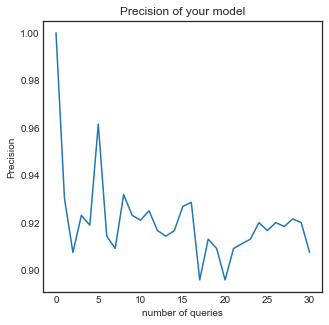

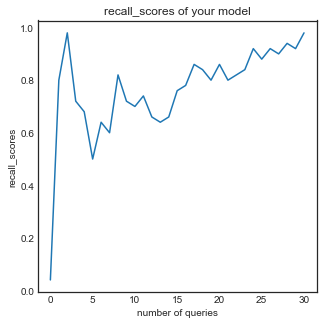

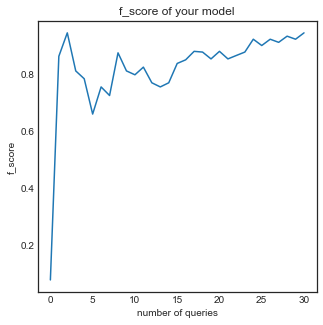

In [149]:
orcl_labels,ams_results_main_no_boot_no_warm = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = False,
                                        warm= False)

Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/747847
https://www.airbnb.nl/rooms/22209978
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 747847 == 22209978
Name : nice cozy room near Vondelpark == Nice, 2-bedroom apartment close to Vondelpark!
postalcode : 1058 BP == 1058 BE
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 2.0
Person_capacity : 1 == 4
Host_first_name : Susanne == Claudia
Host_picture_url : https://a0.muscache.com/im/users/3548522/profile_pic/1347469481/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/17662618/profile_pic/1410189163/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36131 == 52.36204
Lng : 4.8519 == 4.85347
Picture_url : https://a0.muscache.com/im/pictures/29646870/ddc76dc7_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/2134e2b1-e4a0-49aa-bd2c

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/3501084
https://www.airbnb.nl/rooms/16222778
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 3501084 == 16222778
Name : Spacious, light, cosy apt. in the Jordaan district == Private studio apartment in Amsterdam center
postalcode : 1015 NB == 1015 NB
Bedrooms : 2.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Charlotte == Deniz F.
Host_picture_url : https://a0.muscache.com/im/users/17629159/profile_pic/1405272533/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/d6edb887-a605-4a34-ae15-60f1ea910d6a.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37995 == 52.38001
Lng : 4.88577 == 4.88587
Picture_url : https://a0.muscache.com/im/pictures/054598f3-a590-4a11-a4a5-e9aee0a3625b.jpg?aki_policy=large == https://a0.m

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/46374246
https://www.airbnb.nl/rooms/31453479
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 46374246 == 31453479
Name : ???? CANAL APARTMENT | AMSTERDAM CENTRAL | 4P ???? == b&b einstein was here amsterdam centrum albert II
postalcode : 1018 VW == 1018 VG
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Eva & Kobe == Claartje
Host_picture_url : https://a0.muscache.com/im/pictures/user/2df702a0-b346-4dae-b860-c11b0998703d.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/9968b43d-e51e-433f-86da-81511d182b10.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36397 == 52.36469
Lng : 4.91033 == 4.90974
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-46374246/original/fb42dcae-f1e6-4738-9a2a-d1caa8

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/4349963
https://www.airbnb.nl/rooms/4216576
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 4349963 == 4216576
Name : Familie huis in Amsterdam == Heerlijk ruim huis om stad en natuur te bezoeken
postalcode : 1025 LZ == 1022 AB
Bedrooms : 3.0 == 3.0
Bathrooms : 1.0 == 15.0
Beds : 5.0 == 3.0
Person_capacity : 4 == 4
Host_first_name : Gerard == Esther
Host_picture_url : https://a0.muscache.com/im/users/4100544/profile_pic/1413405840/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/52ea5f6b-b6c2-477e-b027-3694b7a36efa.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamnoord == amsterdamnoord
Lat : 52.39123 == 52.39092
Lng : 4.93339 == 4.93499
Picture_url : https://a0.muscache.com/im/pictures/55457967/c5ff8e99_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/ea5a67a6-3784-4d3e

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/52687629
https://www.airbnb.nl/rooms/14292407
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 52687629 == 14292407
Name : Room 66 - Spacious studio in 'de Pijp', Amsterdam == ROMANTIC BRIGHT PVT STUDIO IN CITY CENTRE *****
postalcode : 1073 VN == 1073 BW
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 15.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Leo == Iago
Host_picture_url : https://a0.muscache.com/im/pictures/user/e556a446-ce6d-4982-999d-0b6fb34b360b.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/c157a549-3dfe-4f8a-a97e-e5b452f70e79.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 1 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.355656 == 52.3565
Lng : 4.898954 == 4.89848
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-52687629/original/fde2edf7-d49d-46a3-9415-865436759dd7.jpeg?aki_p

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/21930458
https://www.airbnb.nl/rooms/1662676
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 21930458 == 1662676
Name : Apartment in Jordaan - Centre of Amsterdam == Cozy 1 BD, centre of Amsterdam
postalcode : 1015 LP == 1015 KE
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 2.0
Person_capacity : 3 == 2
Host_first_name : Daan == Sarah-Jane
Host_picture_url : https://a0.muscache.com/im/users/34637595/profile_pic/1433073634/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/8692172/profile_pic/1379283442/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37858 == 52.37976
Lng : 4.88252 == 4.88293
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-21930458/original/f1aec49c-1e33-472a-955f-fd1f147cab34.jpeg?aki_policy=large == https://a0

1
(12, 93) (12,)
Iteration: 0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/48008144
https://www.airbnb.nl/rooms/48005116
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 48008144 == 48005116
Name : Residences | 2-Bedrooms | Serviced Apartment == Residences | 4-Bedrooms | Serviced Apartment
postalcode : 1072 LK == 1072 LK
Bedrooms : 2.0 == 4.0
Bathrooms : 1.5 == 3.0
Beds : 3.0 == 8.0
Person_capacity : 4 == 8
Host_first_name : Residences == Residences
Host_picture_url : https://a0.muscache.com/im/pictures/user/0ec6c665-603a-4b3e-a88f-e963caca4030.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/0ec6c665-603a-4b3e-a88f-e963caca4030.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdam == amsterdam
Lat : 52.35712 == 52.35712
Lng : 4.89091 == 4.89098
Picture_url : https://a0.muscache.com/im/pictures/3170b1eb-fa6b-418c-98ef-e2522c7c1eb5.jpg?aki_policy=larg

1
Iteration: 2
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/29919544
https://www.airbnb.nl/rooms/29919168
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 29919544 == 29919168
Name : Wonderful, beautiful and quiet place, welcome! == Heerlijke prive kamer net buiten t centrum
postalcode : 1098 NA == 1098 NA
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Fleur == Fleur
Host_picture_url : https://a0.muscache.com/im/pictures/user/fe42347d-95a5-4c65-bc15-72314fe0e5bc.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/fe42347d-95a5-4c65-bc15-72314fe0e5bc.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.35229 == 52.353
Lng : 4.93761 == 4.9381900000000005
Picture_url : https://a0.muscache.com/im/pictures/aa9ad292-9175-49db-adb3-2648a5f1eb96.jpg?aki_policy=large == htt

1
Iteration: 4
Iteration: 5
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/42291217
https://www.airbnb.nl/rooms/42287405
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 42291217 == 42287405
Name : Great room for max 6 people close to Amstel River == Fantastic Amsterdam group apartment close to city centre
postalcode : 1096 AM == 1096 AM
Bedrooms : 1.0 == 4.0
Bathrooms : 1.0 == 2.0
Beds : 6.0 == 12.0
Person_capacity : 6 == 12
Host_first_name : Peter == Peter
Host_picture_url : https://a0.muscache.com/im/pictures/user/5cdd95f8-5645-48c2-a5a5-89a4a836e1a9.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/5cdd95f8-5645-48c2-a5a5-89a4a836e1a9.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.33663 == 52.33696
Lng : 4.9326 == 4.93201
Picture_url : https://a0.muscache.com/im/pictures/09819c90-6628-4b28-be28-c5b3920d4f15.jpg?a

1
Iteration: 7
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/52137043
https://www.airbnb.nl/rooms/18784059
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 52137043 == 18784059
Name : Charming apartment near Vondelpark. == Sunny flat  2 rooftops, sauna, projector & wifi
postalcode : 1053 NE == 1053 JH
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 2.0
Person_capacity : 3 == 4
Host_first_name : Chelsea == José Carlos
Host_picture_url : https://a0.muscache.com/im/pictures/user/f6651be5-7835-4a1c-ba11-dadeec529262.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/fd909527-d87c-4cff-955d-13ce0efd891a.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 1 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36331 == 52.3631
Lng : 4.8646699999999985 == 4.86326
Picture_url : https://a0.muscache.com/im/pictures/27125a7a-f000-4ebd-bd8e-c2bde040d3f4.jpg?aki_policy=large == 

1
Iteration: 9
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/6142928
https://www.airbnb.nl/rooms/6142913
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 6142928 == 6142913
Name : Quiet garden room, private bath, airco, parking == Garden view room, private bath, airco, parking.
postalcode : 1077 XB == 1077 XB
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Yvonne == Yvonne
Host_picture_url : https://a0.muscache.com/im/users/31864995/profile_pic/1432118540/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/31864995/profile_pic/1432118540/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.34269000000001 == 52.34269000000001
Lng : 4.87191 == 4.8719199999999985
Picture_url : https://a0.muscache.com/im/pictures/db675fec-5934-4046-897e-a357216e3bb9.jpg?aki_pol

1
Iteration: 11
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/50987627
https://www.airbnb.nl/rooms/1454784
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 50987627 == 1454784
Name : Charming apt with beautiful garden @ de Pijp == Gezellig appartement Amsterdam, de pijp
postalcode : 1072 LH == 1072 LS
Bedrooms : 2.0 == 1.0
Bathrooms : 15.0 == 15.0
Beds : 2.0 == nan
Person_capacity : 4 == 2
Host_first_name : Viviane == Kalina
Host_picture_url : https://a0.muscache.com/im/users/7305222/profile_pic/1395313163/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/0fd42db2-f934-42ae-9772-684e0ce9880b.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 1 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35167 == 52.35229
Lng : 4.89144 == 4.89105
Picture_url : https://a0.muscache.com/im/pictures/5108d2e3-b614-4f5b-a6ab-0196af8faaa6.jpg?aki_policy=large == https://a0.muscach

1
Iteration: 14
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/46635056
https://www.airbnb.nl/rooms/17564346
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 46635056 == 17564346
Name : Large apartment in 350 year old monument == Sunny Spacious Quiet Penthouse in City Centre
postalcode : 1017 TW == 1017 LC
Bedrooms : 3.0 == 1.0
Bathrooms : 2.0 == 1.5
Beds : 1.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Menno == Chris
Host_picture_url : https://a0.muscache.com/im/pictures/user/9ba15c40-ed1a-431a-bc68-b558e54655f6.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/6992853/profile_pic/1424004526/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36084 == 52.36155
Lng : 4.89542 == 4.8960300000000005
Picture_url : https://a0.muscache.com/im/pictures/856fd0db-fd42-4d89-b2a0-80c17b3ca1e7.jpg?aki_policy=large == ht

1
Iteration: 16
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/947437
https://www.airbnb.nl/rooms/1100569
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 947437 == 1100569
Name : Spacious room in quiet neighborhood == bright room + private roof terrace
postalcode : 1069 DA == 1069 HB
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Andre == Andre
Host_picture_url : https://a0.muscache.com/im/pictures/user/5fe91788-eaf0-4b8b-9d32-a4ee81d7c388.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/5fe91788-eaf0-4b8b-9d32-a4ee81d7c388.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdam nieuwwest == amsterdam nieuwwest
Lat : 52.35595 == 52.35622
Lng : 4.79661 == 4.79544
Picture_url : https://a0.muscache.com/im/pictures/39176bbb-4bbc-462d-a5f4-49868a4cca86.jpg?aki_policy=large == https://a0.muscache.com/

1
Iteration: 18
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/15045881
https://www.airbnb.nl/rooms/10112132
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 15045881 == 10112132
Name : Quiet apartment for a couple == Quiet room for a couple or one person
postalcode : 1065 TM == 1065 KK
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 15.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Fernando E Taís == Fernando E Taís
Host_picture_url : https://a0.muscache.com/im/pictures/user/ee1fc6ff-1d33-4829-a6ca-5eceb622440e.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/ee1fc6ff-1d33-4829-a6ca-5eceb622440e.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdam nieuwwest == amsterdam nieuwwest
Lat : 52.35492 == 52.35625
Lng : 4.82909 == 4.8293300000000015
Picture_url : https://a0.muscache.com/im/pictures/06003927-c227-4e94-8cb8-c6bd26557314.jpg?aki_polic

1
Iteration: 20
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/45982523
https://www.airbnb.nl/rooms/45889758
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 45982523 == 45889758
Name : Twin private cabin at Ecomama == Double Private Cabin at Ecomama
postalcode : 1011 LT == 1011 LM
Bedrooms : 1.0 == 1.0
Bathrooms : 0.0 == 0.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Ecomama == Ecomama
Host_picture_url : https://a0.muscache.com/im/pictures/user/417af1f7-6cb7-4594-af5d-0c9b70ca2331.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/417af1f7-6cb7-4594-af5d-0c9b70ca2331.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37091 == 52.37059
Lng : 4.90566 == 4.90639
Picture_url : https://a0.muscache.com/im/pictures/0baae7c6-6ae2-451f-91ab-e25bc806c53f.jpg?aki_policy=large == https://a0.muscache.com/im/pi

1
Iteration: 22
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/52771658
https://www.airbnb.nl/rooms/1320353
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 52771658 == 1320353
Name : 1 stylish jordaan apartment == W Spacious split-level 100m2 Jordaan apartment C
postalcode : 1013 HE == 1015 JD
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 1.5
Beds : nan == 1.0
Person_capacity : 2 == 2
Host_first_name : Remco == Remco
Host_picture_url : https://a0.muscache.com/im/pictures/user/5e3d533e-f442-4251-90f2-70d6d71237d1.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/5e3d533e-f442-4251-90f2-70d6d71237d1.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 1 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.38265 == 52.3815
Lng : 4.8851900000000015 == 4.8853800000000005
Picture_url : https://a0.muscache.com/im/pictures/fe007d59-c1a5-4ebe-ab6a-c6d546a2b990.jpg?aki_policy=large =

1
Iteration: 24
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/29147642
https://www.airbnb.nl/rooms/29147326
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 29147642 == 29147326
Name : Cozy One-Bedroom Apartment at YAYS Salthouse Canal == Peaceful One-Bedroom Apt at YAYS Salthouse Canal
postalcode : 1013 KW == 1013 CT
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Yays Zoutkeetsgracht == Yays Zoutkeetsgracht
Host_picture_url : https://a0.muscache.com/im/pictures/user/b3453781-9096-474c-b323-6226884d1844.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/b3453781-9096-474c-b323-6226884d1844.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.38739 == 52.38772
Lng : 4.88823 == 4.8893
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-29147642/origi

1
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/26177807
https://www.airbnb.nl/rooms/21977982
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 26177807 == 21977982
Name : Da Costa Apartment == Da Costa Suite
postalcode : 1053 XA == 1053 XA
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 3 == 2
Host_first_name : Pieter == Pieter
Host_picture_url : https://a0.muscache.com/im/pictures/user/50bcac3b-5143-4488-8265-fd68700157ef.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/50bcac3b-5143-4488-8265-fd68700157ef.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36643 == 52.36643
Lng : 4.87467 == 4.87465
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-26177807/original/b9d1384f-3708-493c-b6cb-650664d977a6.jpeg?aki_policy=

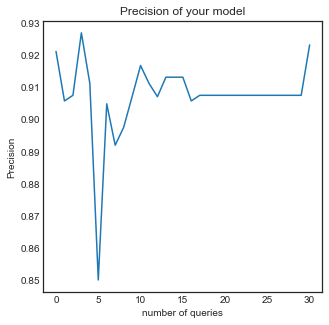

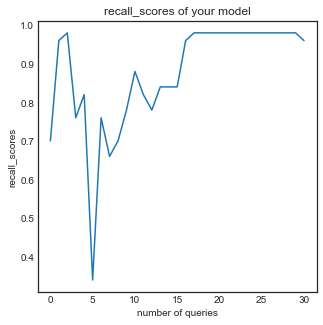

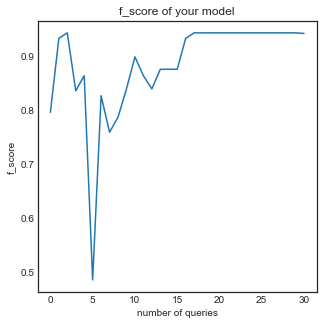

In [153]:
orcl_labels,ams_results_main_no_boot_no_warm_1 = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = False,
                                        warm= False)

Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/2633912
https://www.airbnb.nl/rooms/18410648
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 2633912 == 18410648
Name : Amsterdam Centrum met dakterras voor niet-rokers == Elegant city retreat on canal
postalcode : 1013 HG == 1015 GK
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Agaath == Shuchen
Host_picture_url : https://a0.muscache.com/im/pictures/user/2b34cb33-044c-4e66-a2ae-0e40d49ffc72.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/597881f4-4b31-4f64-b496-19b59ce4568c.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.38308 == 52.38304
Lng : 4.88416 == 4.88376
Picture_url : https://a0.muscache.com/im/pictures/02150dac-f659-471e-ac44-3b05a492d989.jpg?aki_policy=large == https://a0.muscache.com/im/pict

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/39934996
https://www.airbnb.nl/rooms/16249820
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 39934996 == 16249820
Name : Luxurious and spacious place in heart of Amsterdam == Private studio in the center with own bathroom!
postalcode : nan == nan
Bedrooms : 2.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Dirk == Rofaiel & Eva
Host_picture_url : https://a0.muscache.com/im/pictures/user/951e8f8e-ba3f-4f13-882b-7a33ef43e174.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/426da5f5-0d3a-4098-9929-62eb9bf0855a.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : centrumwest == centrumwest
Lat : 52.37125 == 52.37065
Lng : 4.8947400000000005 == 4.89467
Picture_url : https://a0.muscache.com/im/pictures/1048a22b-5d35-47f7-8c7d-390fe3263a02.jpg?aki_policy=large == https://a0

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/4224540
https://www.airbnb.nl/rooms/1694534
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 4224540 == 1694534
Name : Great Private Bedroom in Amsterdam!!! == BIG COZY APARTMENT 
postalcode : 1079 WP == 1079 WL
Bedrooms : 1.0 == 3.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 3.0
Person_capacity : 4 == 4
Host_first_name : Wouter == Brian
Host_picture_url : https://a0.muscache.com/im/users/10565382/profile_pic/1427142490/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/8949817/profile_pic/1379677344/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.34104 == 52.34174
Lng : 4.9039 == 4.90396
Picture_url : https://a0.muscache.com/im/pictures/103920414/413098a5_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/24189832/06cf6785_original.jpg?aki_policy=l

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/29919168
https://www.airbnb.nl/rooms/28236509
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 29919168 == 28236509
Name : Heerlijke prive kamer net buiten t centrum == Four people?  Welcome at Fleur d' Amsterdam
postalcode : 1098 NA == 1098 ND
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 2.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 4
Host_first_name : Fleur == Fleur
Host_picture_url : https://a0.muscache.com/im/pictures/user/fe42347d-95a5-4c65-bc15-72314fe0e5bc.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/fe42347d-95a5-4c65-bc15-72314fe0e5bc.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.353 == 52.35247
Lng : 4.9381900000000005 == 4.93757
Picture_url : https://a0.muscache.com/im/pictures/c8524d41-5fea-45f7-a8f5-2f8b0aaab702.jpg?aki_policy=large == https://a0.muscache

1
Iteration: 2
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/24296667
https://www.airbnb.nl/rooms/23757459
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 24296667 == 23757459
Name : (A) The Lux at Leidse Square GroundFloor 240M2 == (A) Cannabis Friendly - The Lux 2nd floor -420
postalcode : 1017 PL == 1017 PL
Bedrooms : 2.0 == 2.0
Bathrooms : 2.0 == 1.0
Beds : 2.0 == 3.0
Person_capacity : 4 == 4
Host_first_name : Marcel And Pauline == Marcel And Pauline
Host_picture_url : https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36478 == 52.36478
Lng : 4.880330000000002 == 4.880330000000002
Picture_url : https://a0.muscache.com/im/pictures/6b83a54f-fe48-4cd

0
Iteration: 4
Iteration: 5
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/15995195
https://www.airbnb.nl/rooms/14462366
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 15995195 == 14462366
Name : Lovely, spacious Jordaan apartment  in city center == Light / Quiet apartment in Amsterdam city centre
postalcode : 1016 RL == 1016 NM
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 3
Host_first_name : Odine == Clemens
Host_picture_url : https://a0.muscache.com/im/pictures/user/74d6281a-b7b5-4774-bb9e-735695020812.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/22847584/profile_pic/1413997274/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37168 == 52.37301
Lng : 4.88168 == 4.88198
Picture_url : https://a0.muscache.com/im/pictures/842a6338-6c70-4c02-a91f-3ad2b2ece9c7.jpg?aki_p

1
Iteration: 8
Iteration: 9
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/14711799
https://www.airbnb.nl/rooms/10500911
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 14711799 == 10500911
Name : Happy room in Amsterdam == Delightful room
postalcode : 1021 VW == 1021 VZ
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Leonardo == Leonardo
Host_picture_url : https://a0.muscache.com/im/pictures/user/d984cba8-264a-42f0-9513-4ceb3220c511.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/d984cba8-264a-42f0-9513-4ceb3220c511.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamnoord == amsterdamnoord
Lat : 52.38669 == 52.38725
Lng : 4.91925 == 4.92041
Picture_url : https://a0.muscache.com/im/pictures/a83e25bd-bd57-41b5-859c-f533f7bbc3e6.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/4c5ac

1
Iteration: 11
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/25341350
https://www.airbnb.nl/rooms/25338761
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 25341350 == 25338761
Name : Herman Brood apartment canal view == Willem de Kooning apartment garden view
postalcode : 1017 EN == 1017 EN
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Anja == Anja
Host_picture_url : https://a0.muscache.com/im/pictures/user/17e7221f-1970-434b-a76e-9240d8034888.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/17e7221f-1970-434b-a76e-9240d8034888.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.3643 == 52.3643
Lng : 4.8886699999999985 == 4.8886699999999985
Picture_url : https://a0.muscache.com/im/pictures/a5654d31-bd77-4760-8222-d82ac1cb666b.jpg?aki_policy=large == htt

2
[22:44:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Iteration: 14
Iteration: 15
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/27239002
https://www.airbnb.nl/rooms/2534067
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 27239002 == 2534067
Name : Chic&cozy apartment in the hip Pijp area == Paradise in De Pijp!
postalcode : 1072 GH == 1072 LS
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 15.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Greg == Annet
Host_picture_url : https://a0.muscache.com/im/pictures/user/850a0830-0eb6-4a91-9307-ba09a3642f05.jpg?a

0
Iteration: 17
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/53409495
https://www.airbnb.nl/rooms/3708105
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 53409495 == 3708105
Name : Beautiful apartment in the center of Amsterdam == Spacious Apartment in city center
postalcode : 1053 LK == 1053 LM
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 1.5
Beds : 1.0 == 4.0
Person_capacity : 2 == 4
Host_first_name : Pauline == Mijef
Host_picture_url : https://a0.muscache.com/im/users/12493511/profile_pic/1427701548/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/1376907/profile_pic/1407247235/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 1 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.37119738611361 == 52.37075
Lng : 4.873982335837121 == 4.8747099999999985
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-53409495/original/4adfb106-4810-4f1f-87e2-baaad

1
Iteration: 19
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/590681
https://www.airbnb.nl/rooms/13291327
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 590681 == 13291327
Name : Mooi groot familie huis naast Vondelpark == Appartment with garden, 5 min from Vondelpark
postalcode : 1059 BN == 1059 BB
Bedrooms : 4.0 == 2.0
Bathrooms : 2.0 == 15.0
Beds : nan == nan
Person_capacity : 4 == 4
Host_first_name : Lotte == Roderik
Host_picture_url : https://a0.muscache.com/im/pictures/user/b6cd2441-5512-4e78-9a03-42d5d6e31a81.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/e2a4809f-d933-467b-9ebb-91927e7b45ab.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.34788 == 52.34809
Lng : 4.8506 == 4.84857
Picture_url : https://a0.muscache.com/im/pictures/707887c0-5aab-4b57-b69d-dbfba56e32cc.jpg?aki_policy=large == https://a0.musca

1
Iteration: 21
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/40344128
https://www.airbnb.nl/rooms/39646056
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 40344128 == 39646056
Name : Room in renovated apartment in city center! == Luxurious open plan 2 beds apartment in cool area
postalcode : 1094 KN == 1094 XB
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 15.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 4
Host_first_name : Jeroen == Paul
Host_picture_url : https://a0.muscache.com/im/pictures/user/369d3387-5db4-40ba-8904-28d3263acda6.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/692bc38e-46d3-44ea-a4f3-4c9f63d1cb61.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.36253 == 52.36139
Lng : 4.93362 == 4.93392
Picture_url : https://a0.muscache.com/im/pictures/01b58cb0-906f-4c15-af6e-6df1fc18f428.jpg?aki_policy=large == https:

0
Iteration: 23
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/43546419
https://www.airbnb.nl/rooms/22563427
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 43546419 == 22563427
Name : Sun City apartment canal view -Pets&Child friendly == Private B&B city center near Leidseplein
postalcode : nan == nan
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 15.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Sun == Sun
Host_picture_url : https://a0.muscache.com/im/pictures/user/9ebebda5-63e7-4092-b486-a64f26b6d5fb.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/9ebebda5-63e7-4092-b486-a64f26b6d5fb.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : centrumwest == centrumwest
Lat : 52.36789 == 52.36739
Lng : 4.88094 == 4.88015
Picture_url : https://a0.muscache.com/im/pictures/423397fe-a59e-4cad-a01a-620faabbcbd1.jpg?aki_policy=large == https://a0.muscache.com

1
Iteration: 28
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/45763935
https://www.airbnb.nl/rooms/18515604
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 45763935 == 18515604
Name : clean and light apartment nearby the water == nice clean sunny and central room
postalcode : 1013 RJ == 1013 RK
Bedrooms : 2.0 == 1.0
Bathrooms : 1.5 == 1.5
Beds : 2.0 == 1.0
Person_capacity : 1 == 2
Host_first_name : Lisa == Lisa
Host_picture_url : https://a0.muscache.com/im/users/961670/profile_pic/1358886607/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/961670/profile_pic/1358886607/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.39038 == 52.39034
Lng : 4.88191 == 4.88392
Picture_url : https://a0.muscache.com/im/pictures/8b4d4ef5-8b9f-474d-bb7e-0311bbc1b3b4.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/55

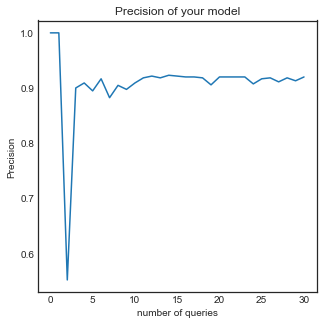

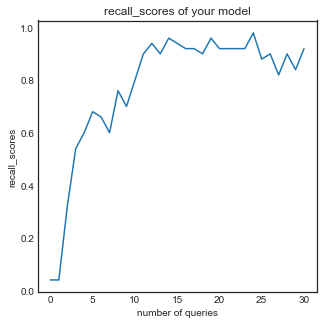

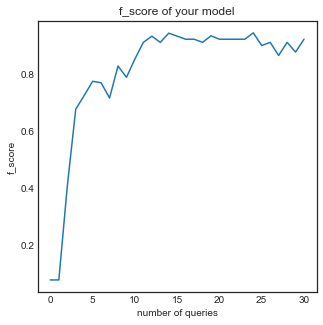

In [156]:
orcl_labels,ams_results_main_no_boot_no_warm_2 = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = False,
                                        warm= False)

Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/36824667
https://www.airbnb.nl/rooms/18234191
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 36824667 == 18234191
Name : Luxe en grote appartement 1H == Canalview & Balconies in hip Old West
postalcode : 1057 PP == 1057 KA
Bedrooms : 2.0 == 2.0
Bathrooms : 1.0 == 1.0
Beds : 4.0 == 2.0
Person_capacity : 4 == 4
Host_first_name : Vlad == Nathalie
Host_picture_url : https://a0.muscache.com/im/pictures/user/2be1ddab-7ec8-4e31-b5aa-b317523085eb.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/6680892/profile_pic/1374304987/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36884000000001 == 52.36944
Lng : 4.86235 == 4.8634
Picture_url : https://a0.muscache.com/im/pictures/8aceead8-09b5-4f0f-95de-b95d8365e5fa.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/af23ef48-

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/415619
https://www.airbnb.nl/rooms/1927634
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 415619 == 1927634
Name : Sunny Amsterdam East Harbor View == Houseboat 140m2, garden, outdoor kitchen, privacy!
postalcode : 1019 DJ == 1019 DD
Bedrooms : 1.0 == 3.0
Bathrooms : 1.0 == 3.0
Beds : 1.0 == 2.0
Person_capacity : 3 == 4
Host_first_name : Stephan == Bauke And Annemiek
Host_picture_url : https://a0.muscache.com/im/users/1336633/profile_pic/1328463417/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/d0d99c9f-406d-4e7c-8cef-f7f03a772d60.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.36905 == 52.36807
Lng : 4.9352800000000006 == 4.93449
Picture_url : https://a0.muscache.com/im/pictures/5123687/f30d1f05_original.jpg?aki_policy=large == https://a0.muscache.com/im/

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/6727439
https://www.airbnb.nl/rooms/17026274
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 6727439 == 17026274
Name : Cosy house for 2 nearby Vondelpark == Modern spacious apartment next to Vondelpark
postalcode : 1058 XJ == 1058 AT
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 15.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 4
Host_first_name : Sabine == Tom
Host_picture_url : https://a0.muscache.com/im/pictures/user/a5bc7238-0fc7-462b-b8aa-27dd8040a01c.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/890250f1-27d1-459f-aaf4-2d8f8f5b9474.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.3606 == 52.35979
Lng : 4.85591 == 4.85529
Picture_url : https://a0.muscache.com/im/pictures/89303432/3f3ae2bd_original.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/miso/Hosting

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/29120704
https://www.airbnb.nl/rooms/15337523
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 29120704 == 15337523
Name : Unieke studio op het water met uitzicht op molen == Spacious 2 room apartment (with rooftop terrace)
postalcode : 1093 ST == 1093 SJ
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : nan == 1.0
Person_capacity : 2 == 2
Host_first_name : Rob == Eric
Host_picture_url : https://a0.muscache.com/im/users/19886464/profile_pic/1407854073/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/87714310-f48e-4450-bdeb-28c364c187cc.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.36579 == 52.36597
Lng : 4.92868 == 4.92716
Picture_url : https://a0.muscache.com/im/pictures/9502f098-3a3f-4e80-b6bf-9ede08f8821c.jpg?aki_policy=large == https://a0.muscache.com/

1
(8, 93) (8,)
Iteration: 0
Iteration: 1
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/49042011
https://www.airbnb.nl/rooms/16270813
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 49042011 == 16270813
Name : Beautiful furnished studio in the Museumkwartier == Fantastic ground floor apartment in the center!
postalcode : 1072 AR == 1072 AR
Bedrooms : nan == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 4
Host_first_name : Saida And Tom == Menke
Host_picture_url : https://a0.muscache.com/im/pictures/user/40fa7927-22e0-400e-8cde-191fa16d2f21.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/f17ef0b9-d58a-4211-a3e1-dc544bd66c92.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35373 == 52.35378
Lng : 4.88715 == 4.88702
Picture_url : https://a0.muscache.com/im/pictures/00937089-8ee5-4af6-a7e5-1ff17574

0
Iteration: 3
Iteration: 4
Iteration: 5
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/41709087
https://www.airbnb.nl/rooms/31945260
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 41709087 == 31945260
Name : Bed in 10 POD Dorm Ensuite == Bed in 8 Bed Dorm Ensuite
postalcode : 1012 JA == 1012 JA
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 1 == 1
Host_first_name : St Christophers At The Winston == St Christophers At The Winston
Host_picture_url : https://a0.muscache.com/im/pictures/user/59f6aec2-6654-4008-99df-520ddedf78aa.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/59f6aec2-6654-4008-99df-520ddedf78aa.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37392 == 52.37392
Lng : 4.89635 == 4.89635
Picture_url : https://a0.muscache.com/im/pictures/aa5a25c8-0a10-4575-8c93-6da3

1
Iteration: 8
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/14817368
https://www.airbnb.nl/rooms/13812250
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 14817368 == 13812250
Name : Amalia Suite == Amalia Residence
postalcode : 1052 GM == 1052 XX
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 4
Host_first_name : Kith & Kin == Kith & Kin
Host_picture_url : https://a0.muscache.com/im/pictures/user/6b1a9b36-d740-431c-8906-5c7590ea5abf.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/6b1a9b36-d740-431c-8906-5c7590ea5abf.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.3792 == 52.37948
Lng : 4.8743300000000005 == 4.8753199999999985
Picture_url : https://a0.muscache.com/im/pictures/47747930-2322-4821-a899-fe8a45160502.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/38c8b

1
Iteration: 12
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/42470025
https://www.airbnb.nl/rooms/10111606
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 42470025 == 10111606
Name : Great Room in best part of Ams (shared Bathroom) == Fantastic Bright Penthouse, Ams Zuid
postalcode : 1076 ED == 1076 KP
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Thierry == Thierry
Host_picture_url : https://a0.muscache.com/im/pictures/user/3d5efaef-d0dc-44e3-b0b2-18394353f0ce.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/3d5efaef-d0dc-44e3-b0b2-18394353f0ce.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.34527 == 52.34411
Lng : 4.86177 == 4.8625300000000005
Picture_url : https://a0.muscache.com/im/pictures/f7d41ebf-9bc0-4551-b1f1-44ef7a175a89.jpg?aki_policy=large == 

1
Iteration: 15
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/52393761
https://www.airbnb.nl/rooms/33504455
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 52393761 == 33504455
Name : Sunny penthouse, rooftop & skylights (Center AMS) == spacious appartment in vibrant area
postalcode : 1053 AS == 1053 WD
Bedrooms : 2.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Eliran == Daan
Host_picture_url : https://a0.muscache.com/im/pictures/user/0bea3f44-23c8-4972-b62a-5dffea436324.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/4082004/profile_pic/1352285153/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.36824 == 52.36846
Lng : 4.86759 == 4.86849
Picture_url : https://a0.muscache.com/im/pictures/91c0aa71-bb45-405f-a872-3089491268cd.jpg?aki_policy=large == https://a0.muscache.

0
Iteration: 17
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/52018552
https://www.airbnb.nl/rooms/23757459
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 52018552 == 23757459
Name : (A) Cannabis Friendly - The Lux 2nd floor -420X == (A) Cannabis Friendly - The Lux 2nd floor -420
postalcode : 1017 ND == 1017 PL
Bedrooms : 2.0 == 2.0
Bathrooms : 1.0 == 1.0
Beds : 3.0 == 3.0
Person_capacity : 4 == 4
Host_first_name : Marcel And Pauline == Marcel And Pauline
Host_picture_url : https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 1 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36546 == 52.36478
Lng : 4.8811 == 4.880330000000002
Picture_url : https://a0.muscache.com/im/pictures/cf90e9ec-54f6-4a5e-9dcd-ae

0
Iteration: 19
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/52771658
https://www.airbnb.nl/rooms/1320438
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 52771658 == 1320438
Name : 1 stylish jordaan apartment == W 100 m2 split-level loft Jordaan apartment D
postalcode : 1013 HE == 1015 JD
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 1.5
Beds : nan == 1.0
Person_capacity : 2 == 2
Host_first_name : Remco == Remco
Host_picture_url : https://a0.muscache.com/im/pictures/user/5e3d533e-f442-4251-90f2-70d6d71237d1.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/5e3d533e-f442-4251-90f2-70d6d71237d1.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 1 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.38265 == 52.3814
Lng : 4.8851900000000015 == 4.88553
Picture_url : https://a0.muscache.com/im/pictures/fe007d59-c1a5-4ebe-ab6a-c6d546a2b990.jpg?aki_policy=large == https://a0.m

0
Iteration: 21
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/44102016
https://www.airbnb.nl/rooms/1109494
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 44102016 == 1109494
Name : Apartment Amsterdam Vondelpark == Nice apartment, center Amsterdam! 
postalcode : 1054 HR == 1054 CV
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Fleur == Ruben
Host_picture_url : https://a0.muscache.com/im/pictures/user/dc6b69d1-6855-4d74-871f-437882c4ff06.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/428c48b0-fd98-498f-8036-c9a4a7495368.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.362 == 52.36262
Lng : 4.87212 == 4.8730400000000005
Picture_url : https://a0.muscache.com/im/pictures/b160e364-2ac8-4660-bbed-a3fcfb7e6a60.jpg?aki_policy=large == https://a0.muscache.com/im/p

1
Iteration: 23
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/42470025
https://www.airbnb.nl/rooms/18105155
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 42470025 == 18105155
Name : Great Room in best part of Ams (shared Bathroom) == Cosy great Apartment in Ams South
postalcode : 1076 ED == 1076 JN
Bedrooms : 1.0 == 3.0
Bathrooms : 1.0 == 15.0
Beds : 1.0 == 3.0
Person_capacity : 2 == 4
Host_first_name : Thierry == Thierry
Host_picture_url : https://a0.muscache.com/im/pictures/user/3d5efaef-d0dc-44e3-b0b2-18394353f0ce.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/3d5efaef-d0dc-44e3-b0b2-18394353f0ce.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.34527 == 52.34479
Lng : 4.86177 == 4.86156
Picture_url : https://a0.muscache.com/im/pictures/f7d41ebf-9bc0-4551-b1f1-44ef7a175a89.jpg?aki_policy=large == https://a0.mu

1
Iteration: 26
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/52687629
https://www.airbnb.nl/rooms/52575047
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 52687629 == 52575047
Name : Room 66 - Spacious studio in 'de Pijp', Amsterdam == Suite 7 - Big sunny studio in 'de Pijp', Amsterdam
postalcode : 1073 VN == 1073 VN
Bedrooms : 1.0 == 1.0
Bathrooms : 15.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Leo == Leo
Host_picture_url : https://a0.muscache.com/im/pictures/user/e556a446-ce6d-4982-999d-0b6fb34b360b.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/e556a446-ce6d-4982-999d-0b6fb34b360b.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 1 == 1
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.355656 == 52.355644
Lng : 4.898954 == 4.89889
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-52687629/original/fde2edf7-d49d-46a3-9415-865436

0
Iteration: 28
Iteration: 29
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/11178448
https://www.airbnb.nl/rooms/10700796
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 11178448 == 10700796
Name : Vondelpark House Bed & Breakfast Room 2. == Vondelpark House Bed & Breakfast Room 1.
postalcode : 1054 LR == 1054 LM
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Petra == Petra
Host_picture_url : https://a0.muscache.com/im/pictures/user/94f83fa2-5518-48f3-9962-4a8a0a9e42d7.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/94f83fa2-5518-48f3-9962-4a8a0a9e42d7.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.35749000000001 == 52.35849
Lng : 4.85803 == 4.85721
Picture_url : https://a0.muscache.com/im/pictures/165cf5af-074c-4dac-9d1d-e4becded45dd.jpg?aki_policy=large

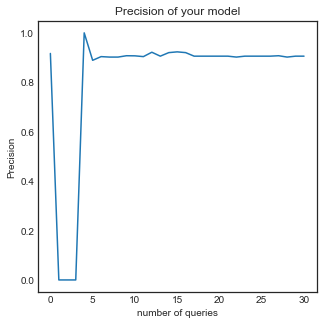

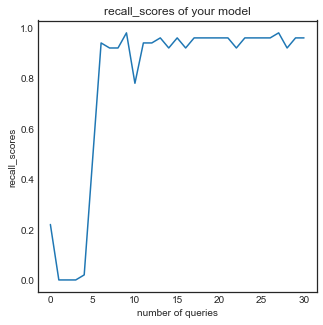

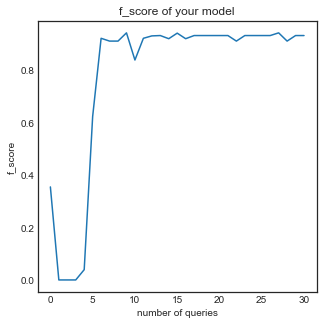

In [168]:
orcl_labels,ams_results_main_no_boot_no_warm_3 = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = False,
                                        warm= False)

Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/27397058
https://www.airbnb.nl/rooms/12744183
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 27397058 == 12744183
Name : Cozy room in stylish apartment == Beautiful roofterrace apartment
postalcode : 1056 SE == 1057 KP
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Enneke == Mark
Host_picture_url : https://a0.muscache.com/im/users/8571784/profile_pic/1378253481/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/3d08080c-b219-4954-96ef-156ff25ed662.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.37108 == 52.37002
Lng : 4.85303 == 4.85226
Picture_url : https://a0.muscache.com/im/pictures/7cc00393-2adb-4910-9d6c-2648755939d5.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/4862dce3-1631-4927-9e71

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/20987240
https://www.airbnb.nl/rooms/19641424
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 20987240 == 19641424
Name : Wonderfully large, light and spacious!! == Super design flat with garden, close to everything
postalcode : 1078 VS == 1078 DP
Bedrooms : 4.0 == 3.0
Bathrooms : 25.0 == 2.0
Beds : 8.0 == 5.0
Person_capacity : 8 == 7
Host_first_name : Regina == Marco
Host_picture_url : https://a0.muscache.com/im/users/14590304/profile_pic/1413967762/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/2610108/profile_pic/1339457457/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.34611 == 52.34669
Lng : 4.89266 == 4.89401
Picture_url : https://a0.muscache.com/im/pictures/ef330238-86c4-4b0f-81eb-f67e32ff4f7a.jpg?aki_policy=large == https://a0.muscache.com/im/pict

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/37732527
https://www.airbnb.nl/rooms/22299023
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 37732527 == 22299023
Name : Big Bedroom With Private Bathroom,good atmospheric == Canal view apartment | City centre | Balcony
postalcode : 1018 XZ == 1018 XK
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Isabella == Joeri
Host_picture_url : https://a0.muscache.com/im/pictures/user/51882193-be42-4948-8e41-6f452ed4d856.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/70e14d7d-4562-4af2-8322-b4b0826d3a05.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36197 == 52.36286
Lng : 4.905469999999998 == 4.90576
Picture_url : https://a0.muscache.com/im/pictures/1a21e548-0630-4d4d-996b-a92fc051cfd5.jpg?aki_policy=large == 

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/15351762
https://www.airbnb.nl/rooms/15038670
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 15351762 == 15038670
Name : Beautiful, cosy apartment in bubbly Amsterdam East == Modern & fresh studio in trendy area
postalcode : 1094 GS == 1094 GK
Bedrooms : 1.0 == 1.0
Bathrooms : 1.5 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Jack == Ilana
Host_picture_url : https://a0.muscache.com/im/pictures/user/86c3694e-7fce-4f70-8881-29f7c61430ae.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/10079417/profile_pic/1385114620/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.36428 == 52.36446
Lng : 4.935969999999998 == 4.93719
Picture_url : https://a0.muscache.com/im/pictures/e4ee1905-3b7c-4ba7-bc8f-f13a1ab458e9.jpg?aki_policy=large == https://a0.muscache.co

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/15109768
https://www.airbnb.nl/rooms/12216213
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 15109768 == 12216213
Name : Amazing location on Noordermarkt/Prinsengracht == Captain's Quarters in Classic Ship
postalcode : 1015 NA == 1015 DV
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Ingeborg == Barbara
Host_picture_url : https://a0.muscache.com/im/pictures/user/86f07969-7467-4597-b3b6-67c0c1449972.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/710de593-01e2-4c93-8d83-b827a44bac89.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.380138 == 52.38001
Lng : 4.887468 == 4.88794
Picture_url : https://a0.muscache.com/im/pictures/5671259a-f05a-48dd-8633-4215b6547aa2.jpg?aki_policy=large == https://a0.muscache.

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/20190961
https://www.airbnb.nl/rooms/15527704
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 20190961 == 15527704
Name : Unique Peaceful Houseboat next to the city centre == Private studio on lovely houseboat. Great location
postalcode : 1013 CP == 1013 CR
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 3 == 2
Host_first_name : Sjoerd == Frank
Host_picture_url : https://a0.muscache.com/im/pictures/user/93e59015-ae28-4e64-ae70-2264f3fd1ff1.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/c9b5a5d8-df96-45d6-9f83-47563965cb82.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.390259 == 52.39112
Lng : 4.888995 == 4.88785
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-20190961/original/e48b097f-fbec-44a8-9dbf-184f24baaef5.jpeg

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/21687625
https://www.airbnb.nl/rooms/10549599
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 21687625 == 10549599
Name : Canal house next to Amsterdam CS. Perfect for Fam. == amazing apt in the city center
postalcode : 1011 BG == 1011 AM
Bedrooms : 3.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 6.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Friederike == Patricia
Host_picture_url : https://a0.muscache.com/im/pictures/user/865ef63a-061d-44ba-ae26-02cc89463d8f.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/4ffd6d34-acc3-4ee9-92c4-bd152613cbd9.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37347000000001 == 52.37427
Lng : 4.903969999999998 == 4.90485
Picture_url : https://a0.muscache.com/im/pictures/edf4e632-dbfa-48c3-8da9-1a1dd1fe640d.jpg?aki_policy=large == 

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/42743807
https://www.airbnb.nl/rooms/26516140
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 42743807 == 26516140
Name : Pestana Amsterdam Riverside, Mezzanine Suite == Houseboat on Amstel river in De Pijp district
postalcode : 1074 VM == 1074 JH
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : nan == 2.0
Person_capacity : 2 == 2
Host_first_name : Pestana Amsterdam Riverside == Louk
Host_picture_url : https://a0.muscache.com/im/pictures/user/e052af75-f25b-4514-8bc1-843612be8616.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/69875a8c-24ff-4ba3-8c4d-8a665b751d15.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35269 == 52.35289
Lng : 4.9059 == 4.90798
Picture_url : https://a0.muscache.com/im/pictures/119de0bb-cadb-479a-98af-bcbd8899336f.jpg?aki_policy=large == http

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/729260
https://www.airbnb.nl/rooms/31820294
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 729260 == 31820294
Name : Great location modern apartment == Tulip Apartment 2 rooms 2 baths Central Amsterdam
postalcode : 1015 JK == 1015 LG
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 2.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 4
Host_first_name : Martin == Mila
Host_picture_url : https://a0.muscache.com/im/users/3788198/profile_pic/1406581384/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/eb9113f8-b9e4-44f1-8e0c-0ddc63c05ada.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.38079000000001 == 52.37978
Lng : 4.88536 == 4.88445
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-729260/original/3799ab75-5e9e-496a-a4b9-e30986b90c2d.jpeg?aki_policy=large 

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/27851626
https://www.airbnb.nl/rooms/24742530
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 27851626 == 24742530
Name : Sunny, cozy, urban oasis in central AMS == Lovely family apartment
postalcode : 1052 HN == 1052 LL
Bedrooms : 1.0 == 3.0
Bathrooms : 1.5 == 3.0
Beds : 1.0 == 6.0
Person_capacity : 2 == 6
Host_first_name : Florence == Leon
Host_picture_url : https://a0.muscache.com/im/pictures/user/fc03bbf2-b50e-47af-bd60-e45e7d31b42c.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/53df6b34-8397-4b59-a778-83830c4338f3.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.37401 == 52.37383
Lng : 4.87283 == 4.87286
Picture_url : https://a0.muscache.com/im/pictures/6c158e98-7a79-4666-9b7b-355c1a736809.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/f6ae074d-3981

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/44009299
https://www.airbnb.nl/rooms/30041153
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 44009299 == 30041153
Name : Cosy center apartment with canal view and garden == a lovely place in Amsterdam
postalcode : 1013 MP == 1013 PD
Bedrooms : 1.0 == 2.0
Bathrooms : 1.5 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 4
Host_first_name : Diederik == Alejandro
Host_picture_url : https://a0.muscache.com/im/users/7975382/profile_pic/1375796725/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/c594d163-c02e-453b-b299-f2cf188aa7a1.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.38995 == 52.38939
Lng : 4.88581 == 4.88606
Picture_url : https://a0.muscache.com/im/pictures/2faf5cb5-080c-4de0-b43c-7cd13a0a9ec4.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/44733441
https://www.airbnb.nl/rooms/44586588
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 44733441 == 44586588
Name : Daisy Studio == Green Alley Studio
postalcode : 1012 TR == 1012 SP
Bedrooms : 0.0 == 0.0
Bathrooms : 1.0 == 1.0
Beds : nan == 1.0
Person_capacity : 2 == 4
Host_first_name : Marco == Tijl & Roos
Host_picture_url : https://a0.muscache.com/im/pictures/user/60c0a46c-64ae-4cee-9d9e-f714f6208cf9.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/32b0adbd-8870-4083-b9f5-d30211fff3c8.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37792 == 52.37733
Lng : 4.89669 == 4.8947699999999985
Picture_url : https://a0.muscache.com/im/pictures/b8f1afb4-b4e6-42b4-adc4-3666531c1077.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/cfcb4507-c4c0-405e-b467-

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/4147932
https://www.airbnb.nl/rooms/402353
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 4147932 == 402353
Name : Nice 45m2  private room with shower&roofterrace == Comfortable design apartment with roof terrace
postalcode : 1098 JC == 1098 KK
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Enith == Lidy
Host_picture_url : https://a0.muscache.com/im/users/21488545/profile_pic/1411328092/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/2008330/profile_pic/1343472579/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamoost == amsterdamoost
Lat : 52.35396 == 52.35338
Lng : 4.93526 == 4.934069999999998
Picture_url : https://a0.muscache.com/im/pictures/076a0dcf-1053-48e8-920d-ca15a77f7f5c.jpg?aki_policy=large == https://a0.muscache.com/im

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/4029316
https://www.airbnb.nl/rooms/21363769
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 4029316 == 21363769
Name : Cosy Studio apartment == Nice house near the center and RAI.
postalcode : 1071 XW == 1072 JW
Bedrooms : 1.0 == 2.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 2.0
Person_capacity : 2 == 4
Host_first_name : Jerome == Denise
Host_picture_url : https://a0.muscache.com/im/pictures/user/403547f2-69b7-429e-9f43-300312abc21d.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/f79b3bc6-bedb-4efd-820f-72d5008cbced.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamzuid == amsterdamzuid
Lat : 52.35098 == 52.34997
Lng : 4.8861 == 4.88727
Picture_url : https://a0.muscache.com/im/pictures/1cf23e43-e02e-4a4d-8c98-d1e36b5ea106.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/13b9c600-6fac-483b-99e

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/15911681
https://www.airbnb.nl/rooms/1105128
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 15911681 == 1105128
Name : Lovely apartment in a quiet street in the center == Houseboat Neeltje unique experience
postalcode : 1011 TL == 1011 TE
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 1.0 == 1.0
Person_capacity : 2 == 2
Host_first_name : Cor == Stijn
Host_picture_url : https://a0.muscache.com/im/users/8492548/profile_pic/1378070202/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/users/6063077/profile_pic/1366916126/original.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37186 == 52.37309000000001
Lng : 4.90793 == 4.90845
Picture_url : https://a0.muscache.com/im/pictures/8f9a0b33-0a3a-4543-b7aa-a4ee1c2336c6.jpg?aki_policy=large == https://a0.muscache.com/im/pi

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/5109339
https://www.airbnb.nl/rooms/33555554
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 5109339 == 33555554
Name : Apartment in city center! == Room in bright and new Jordaan apartment
postalcode : 1016 KV == 1016 KC
Bedrooms : 0.0 == 1.0
Bathrooms : 1.0 == 1.5
Beds : 2.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Cees&Co == Kristian
Host_picture_url : https://a0.muscache.com/im/users/26401097/profile_pic/1434351180/original.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/b39fec00-691f-458e-9563-e9c108264a8f.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.37422 == 52.37477
Lng : 4.88225 == 4.88184
Picture_url : https://a0.muscache.com/im/pictures/265e5a23-36d6-43fa-b777-eb4dc1aad5fb.jpg?aki_policy=large == https://a0.muscache.com/im/pictures/09423a0

0
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/29117307
https://www.airbnb.nl/rooms/29003498
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 29117307 == 29003498
Name : Duplex 1-Bedroom Apt at YAYS Amsterdam Maritime == Modern Duplex Studio at YAYS Amsterdam Maritime
postalcode : 1018 WW == 1018 WW
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 1.0
Beds : 2.0 == 1.0
Person_capacity : 4 == 2
Host_first_name : Yays Oostenburgergracht == Yays Oostenburgergracht
Host_picture_url : https://a0.muscache.com/im/pictures/user/40766d8b-793c-4861-8e5e-6e5e3ef008ad.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/40766d8b-793c-4861-8e5e-6e5e3ef008ad.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 0 == 0
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36722 == 52.36758
Lng : 4.92265 == 4.92277
Picture_url : https://a0.muscache.com/im/pictures/miso/Hosting-29117307/original/92c7459

1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/34099666
https://www.airbnb.nl/rooms/1792271
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 34099666 == 1792271
Name : Private room in sunny, quiet garden apt (with dog) == Spacious Apartment near Westerpark
postalcode : 1013 SB == 1013 SB
Bedrooms : 1.0 == 1.0
Bathrooms : 1.0 == 15.0
Beds : 1.0 == 1.0
Person_capacity : 1 == 2
Host_first_name : Olga == Ivo
Host_picture_url : https://a0.muscache.com/im/pictures/user/81b382c0-dbed-4628-9cb4-184f7ae77cf8.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/a20f56fd-7523-4900-869e-6553957cb27c.jpg?aki_policy=profile_x_medium
Instant_bookable : 0 == 0
Is_new_listing : 0 == 0
Neighborhood : amsterdamwest == amsterdamwest
Lat : 52.39073 == 52.39051
Lng : 4.87191 == 4.87076
Picture_url : https://a0.muscache.com/im/pictures/369ffbd2-2e6a-4fc8-b870-08d71

0
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/52018552
https://www.airbnb.nl/rooms/51950666
Links retreived
2
site : AIRBNB == AIRBNB
ListingId : 52018552 == 51950666
Name : (A) Cannabis Friendly - The Lux 2nd floor -420X == (A) Cannabis Friendly - The Lux 2nd floor -420
postalcode : 1017 ND == 1017 PL
Bedrooms : 2.0 == 2.0
Bathrooms : 1.0 == 1.0
Beds : 3.0 == 3.0
Person_capacity : 4 == 4
Host_first_name : Marcel And Pauline == Marcel And Pauline
Host_picture_url : https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium == https://a0.muscache.com/im/pictures/user/2483da15-7fbf-4166-ae18-5a9bb5ce3d07.jpg?aki_policy=profile_x_medium
Instant_bookable : 1 == 1
Is_new_listing : 1 == 1
Neighborhood : amsterdamcentrum == amsterdamcentrum
Lat : 52.36546 == 52.364788
Lng : 4.8811 == 4.880334
Pi

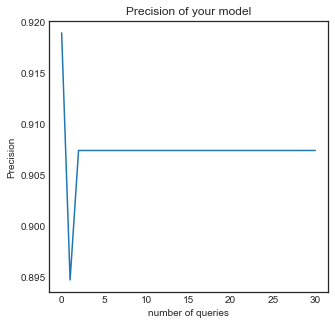

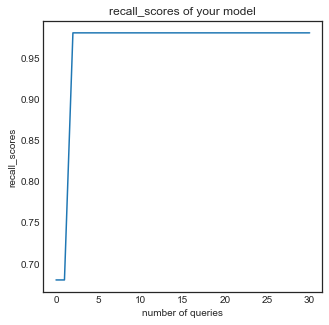

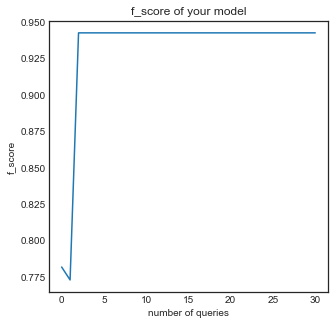

In [170]:
orcl_labels,ams_results_main_no_boot_no_warm_4 = al(df_ams_train,df_ams_test,queries=30,
                                        baseline=False,committee_pred= False,
                                        incremental_comitee = False,boostrap = False,
                                        warm= False)

In [171]:
#Take out the labeled data for making a test set 
manual_labeled = []

for (tuple_1,tuple_2),label in orcl_labels:
    if label ==2 :
        manual_labeled.append([str((tuple_1,tuple_2)),np.float('nan')])
        manual_labeled.append([str((tuple_2,tuple_1)),np.float('nan')])
    else:    
        manual_labeled.append([str((tuple_1,tuple_2)),label])
        manual_labeled.append([str((tuple_2,tuple_1)),label])

#Save the labeled data into the main dataframe
for tuples,label in manual_labeled:
    df_ams_train['label'][df_ams_train['ids']== tuples] = label
df_ams_train.to_csv('df_ams_train_nh_1.csv',index=False)

In [173]:
resuts_no_boot_no_warm_ams = [ams_results_main_no_boot_no_warm_4,ams_results_main_no_boot_no_warm_3,ams_results_main_no_boot_no_warm_2
                     ,ams_results_main_no_boot_no_warm_1,ams_results_main_no_boot_no_warm]

file_name = "resuts_no_boot_no_warm_ams.pkl"

open_file = open(file_name, "wb")
pickle.dump(resuts_no_boot_no_warm_ams, open_file)
open_file.close()

In [175]:
#Create an average of the 5 runs of the active learning set up 
precision_full_rf = []
recall_full_rf = []
f_score_full_rf = []

precision_no_boot_rf = []
recall_no_boot_rf = []
f_score_no_boot_rf = []

precision_rf_noboot_nowarm = []
recall_rf_noboot_nowarm = []
f_score_rf_noboot_nowarm = []

for dicts in resuts_full_ams:
    precision_full_rf.append(dicts['precision_scores'])
    recall_full_rf.append(dicts['recall_scores'])
    f_score_full_rf.append(dicts['f_score'])

precision_full_rf_mean =np.mean(precision_full_rf,axis=0)
recall_full_rf_mean =np.mean(recall_full_rf,axis=0)
f_score_full_rf_mean = np.mean(f_score_full_rf,axis=0)

precision_full_rf_sd =np.std(precision_full_rf,axis=0)
recall_full_rf_sd =np.std(recall_full_rf,axis=0)
f_score_full_rf_sd = np.std(f_score_full_rf,axis=0)


for dicts in resuts_noboot_ams:
    precision_no_boot_rf.append(dicts['precision_scores'])
    recall_no_boot_rf.append(dicts['recall_scores'])
    f_score_no_boot_rf.append(dicts['f_score'])

precision_no_boot_rf_mean =np.mean(precision_no_boot_rf,axis=0)
recall_no_boot_rf_mean =np.mean(recall_no_boot_rf,axis=0)
f_score_no_boot_rf_mean = np.mean(f_score_no_boot_rf,axis=0)

precision_no_boot_rf_sd =np.std(precision_no_boot_rf,axis=0)
recall_no_boot_rf_sd =np.std(recall_no_boot_rf,axis=0)
f_score_no_boot_rf_sd = np.std(f_score_no_boot_rf,axis=0)

for dicts in resuts_no_boot_no_warm_ams:
    precision_rf_noboot_nowarm.append(dicts['precision_scores'])
    recall_rf_noboot_nowarm.append(dicts['recall_scores'])
    f_score_rf_noboot_nowarm.append(dicts['f_score'])

precision_rf_noboot_nowarm_mean =np.mean(precision_rf_noboot_nowarm,axis=0)
recall_rf_noboot_nowarm_mean =np.mean(recall_rf_noboot_nowarm,axis=0)
f_score_rf_noboot_nowarm_mean = np.mean(f_score_rf_noboot_nowarm,axis=0)

precision_rf_noboot_nowarm_sd =np.std(precision_rf_noboot_nowarm,axis=0)
recall_rf_noboot_nowarm_mean =np.std(recall_rf_noboot_nowarm,axis=0)
f_score_rf_noboot_nowarm_sd = np.std(f_score_rf_noboot_nowarm,axis=0)

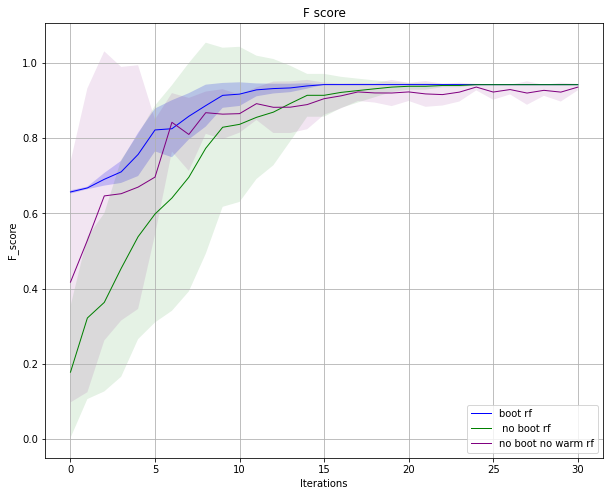

In [177]:
from matplotlib.pyplot import figure

fig, ax = plt.subplots(1)
fig.set_size_inches(10,8)
ax.plot(np.arange(31), f_score_full_rf_mean, lw=1, label='boot rf', color='blue')

ax.plot(np.arange(31), f_score_no_boot_rf_mean, lw=1, label=' no boot rf', color='green')
ax.plot(np.arange(31), f_score_rf_noboot_nowarm_mean, lw=1, label='no boot no warm rf', color='purple')
#ax.plot([0, 31], [0.7959183673469387,0.7959183673469387], 'k-', lw=2)
ax.fill_between(np.arange(31), f_score_full_rf_mean + f_score_full_rf_sd, f_score_full_rf_mean-f_score_full_rf_sd
                ,facecolor='blue', alpha=0.2)

ax.fill_between(np.arange(31), f_score_no_boot_rf_mean + f_score_no_boot_rf_sd, f_score_no_boot_rf_mean-f_score_no_boot_rf_sd
                ,facecolor='green', alpha=0.1)
ax.fill_between(np.arange(31), f_score_rf_noboot_nowarm_mean + f_score_rf_noboot_nowarm_sd, f_score_rf_noboot_nowarm_mean-f_score_rf_noboot_nowarm_sd
                ,facecolor='purple', alpha=0.1)                                
ax.set_title('F score')
ax.legend(loc='lower right')
ax.set_xlabel('Iterations')
ax.set_ylabel('F_score')

ax.grid()

In [ ]:
resuts_full_comitte = []
for i in range(5):    
    _,dict_results_com = al(df_base_train,df_test = df_base_test ,queries=100,
                                        baseline=True,committee_pred= True,
                                        incremental_comitee = True,boostrap = True,
                                        warm= True)
    resuts_full_comitte.append(dict_results_com)


In [34]:
file_name = "resuts_full_comitte.pkl"

open_file = open(file_name, "wb")
pickle.dump(resuts_full_comitte, open_file)
open_file.close()

'open_file = open(file_name, "rb")\nloaded_list = pickle.load(open_file)\nopen_file.close()'

In [38]:
resuts_full_rf = []
for i in range(5):   
    _,dict_results_main = al(df_base_train,df_test = df_base_test ,queries=100,
                                        baseline=True,committee_pred= False,
                                        incremental_comitee = False,boostrap = True,
                                        warm=True)
    resuts_full_rf.append(dict_results_main)


Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware que

In [35]:
file_name = "resuts_full_rf.pkl"

open_file = open(file_name, "wb")
pickle.dump(resuts_full_rf, open_file)
open_file.close()

In [83]:
resuts_rf_no_boot = []
for i in range(5): 
    _,dict_results_main_no_boot = al(df_base_train,df_test = df_base_test ,queries=100,
                                        baseline=True,committee_pred= False,
                                        incremental_comitee = False,boostrap = False,
                                        warm=True)
    resuts_rf_no_boot.append(dict_results_main_no_boot)

(4, 131) (4,)
(4, 131) (4,)
(7, 131) (7,)
(2, 131) (2,)
(8, 131) (8,)


In [93]:
file_name = "resuts_rf_no_boot.pkl"

open_file = open(file_name, "wb")
pickle.dump(resuts_rf_no_boot, open_file)
open_file.close()

In [24]:
resuts_rf_noboot_nowarm = []
for i in range(5):
    _,dict_results_main_no_boot_no_warm = al(df_base_train,df_test = df_base_test ,queries=100,
                                        baseline=True,committee_pred= False,
                                        incremental_comitee = False,boostrap=False,
                                        warm=False)
    resuts_rf_noboot_nowarm.append(dict_results_main_no_boot_no_warm)

(2, 131) (2,)
(10, 131) (10,)
(3, 131) (3,)
(29, 131) (29,)
(2, 131) (2,)


In [37]:
file_name = "resuts_rf_noboot_nowarm.pkl"

open_file = open(file_name, "wb")
pickle.dump(resuts_rf_noboot_nowarm, open_file)
open_file.close()

In [46]:
file_name = 'resuts_full_rf.pkl'
open_file = open(file_name, "rb")
resuts_full_rf = pickle.load(open_file)
open_file.close()

file_name = 'resuts_full_comitte.pkl'
open_file = open(file_name, "rb")
resuts_full_comitte = pickle.load(open_file)
open_file.close()

file_name = 'resuts_rf_no_boot.pkl'
open_file = open(file_name, "rb")
resuts_rf_no_boot = pickle.load(open_file)
open_file.close()

file_name = 'resuts_rf_noboot_nowarm.pkl'
open_file = open(file_name, "rb")
resuts_noboot_nowarm = pickle.load(open_file)
open_file.close()

In [84]:
#Create an average of the 5 runs of the active learning set up 
precision_full_rf = []
recall_full_rf = []
f_score_full_rf = []

precision_full_cmt = []
recall_full_cmt = []
f_score_full_cmt = []

precision_no_boot_rf = []
recall_no_boot_rf = []
f_score_no_boot_rf = []

precision_rf_noboot_nowarm = []
recall_rf_noboot_nowarm = []
f_score_rf_noboot_nowarm = []

for dicts in resuts_full_rf:
    precision_full_rf.append(dicts['precision_scores'])
    recall_full_rf.append(dicts['recall_scores'])
    f_score_full_rf.append(dicts['f_score'])

precision_full_rf_mean =np.mean(precision_full_rf,axis=0)
recall_full_rf_mean =np.mean(recall_full_rf,axis=0)
f_score_full_rf_mean = np.mean(f_score_full_rf,axis=0)

precision_full_rf_sd =np.std(precision_full_rf,axis=0)
recall_full_rf_sd =np.std(recall_full_rf,axis=0)
f_score_full_rf_sd = np.std(f_score_full_rf,axis=0)

for dicts in resuts_full_comitte:
    precision_full_cmt.append(dicts['precision_scores'])
    recall_full_cmt.append(dicts['recall_scores'])
    f_score_full_cmt.append(dicts['f_score'])

precision_full_cmt_mean =np.mean(precision_full_cmt,axis=0)
recall_full_cmt_mean =np.mean(recall_full_cmt,axis=0)
f_score_full_cmt_mean = np.mean(f_score_full_cmt,axis=0)

precision_full_cmt_sd =np.std(precision_full_cmt,axis=0)
recall_full_cmt_sd =np.std(recall_full_cmt,axis=0)
f_score_full_cmt_sd = np.std(f_score_full_cmt,axis=0)

for dicts in resuts_rf_no_boot:
    precision_no_boot_rf.append(dicts['precision_scores'])
    recall_no_boot_rf.append(dicts['recall_scores'])
    f_score_no_boot_rf.append(dicts['f_score'])

precision_no_boot_rf_mean =np.mean(precision_no_boot_rf,axis=0)
recall_no_boot_rf_mean =np.mean(recall_no_boot_rf,axis=0)
f_score_no_boot_rf_mean = np.mean(f_score_no_boot_rf,axis=0)

precision_no_boot_rf_sd =np.std(precision_no_boot_rf,axis=0)
recall_no_boot_rf_sd =np.std(recall_no_boot_rf,axis=0)
f_score_no_boot_rf_sd = np.std(f_score_no_boot_rf,axis=0)

for dicts in resuts_rf_noboot_nowarm:
    precision_rf_noboot_nowarm.append(dicts['precision_scores'])
    recall_rf_noboot_nowarm.append(dicts['recall_scores'])
    f_score_rf_noboot_nowarm.append(dicts['f_score'])

precision_rf_noboot_nowarm_mean =np.mean(precision_rf_noboot_nowarm,axis=0)
recall_rf_noboot_nowarm_mean =np.mean(recall_rf_noboot_nowarm,axis=0)
f_score_rf_noboot_nowarm_mean = np.mean(f_score_rf_noboot_nowarm,axis=0)

precision_rf_noboot_nowarm_sd =np.std(precision_rf_noboot_nowarm,axis=0)
recall_rf_noboot_nowarm_mean =np.std(recall_rf_noboot_nowarm,axis=0)
f_score_rf_noboot_nowarm_sd = np.std(f_score_rf_noboot_nowarm,axis=0)

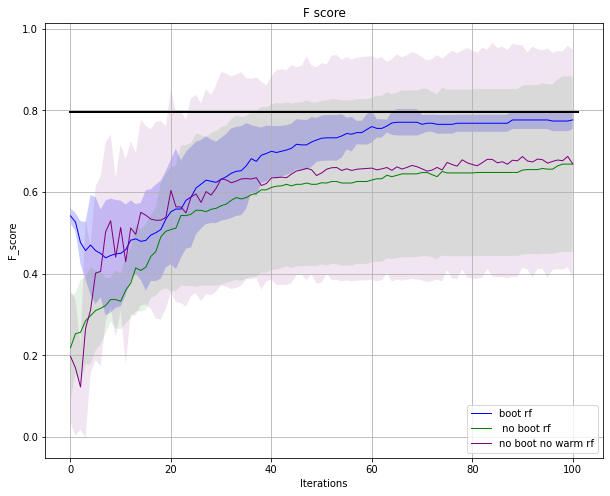

In [103]:
from matplotlib.pyplot import figure
fig, ax = plt.subplots(1)
fig.set_size_inches(10,8)
ax.plot(np.arange(101), f_score_full_rf_mean, lw=1, label='boot rf', color='blue')
#ax.plot(np.arange(101), f_score_full_cmt_mean, lw=1, label='boot committee', color='red')
ax.plot(np.arange(101), f_score_no_boot_rf_mean, lw=1, label=' no boot rf', color='green')
ax.plot(np.arange(101), f_score_rf_noboot_nowarm_mean, lw=1, label='no boot no warm rf', color='purple')
ax.plot([0, 101], [0.7959183673469387,0.7959183673469387], 'k-', lw=2)
ax.fill_between(np.arange(101), f_score_full_rf_mean + f_score_full_rf_sd, f_score_full_rf_mean-f_score_full_rf_sd
                ,facecolor='blue', alpha=0.2)
#ax.fill_between(np.arange(101), f_score_full_cmt_mean + f_score_full_cmt_sd, f_score_full_cmt_mean-f_score_full_cmt_sd
#                ,facecolor='red', alpha=0.2)
ax.fill_between(np.arange(101), f_score_no_boot_rf_mean + f_score_no_boot_rf_sd, f_score_no_boot_rf_mean-f_score_no_boot_rf_sd
                ,facecolor='green', alpha=0.1)
ax.fill_between(np.arange(101), f_score_rf_noboot_nowarm_mean + f_score_rf_noboot_nowarm_sd, f_score_rf_noboot_nowarm_mean-f_score_rf_noboot_nowarm_sd
                ,facecolor='purple', alpha=0.1)                                
ax.set_title('F score')
ax.legend(loc='lower right')
ax.set_xlabel('Iterations')
ax.set_ylabel('F_score')

ax.grid()